In [62]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators, compute_individual_grads_nothread
from GGH.models import initialize_model, load_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, visualize_train_val_error, selection_histograms
from GGH.custom_optimizer import CustomAdam
from sklearn.metrics import r2_score
from torch.autograd import grad
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def set_to_deterministic(rand_state):
    import random
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)

print("Imports successful!")

Imports successful!


In [63]:
# Data configuration
data_path = '../data/wine/red_wine.csv'
results_path = "../saved_results/Red Wine Hybrid Iterative"
inpt_vars = ['volatile acidity', 'total sulfur dioxide', 'citric acid'] 
target_vars = ['quality']
miss_vars = ['alcohol']

# Hypothesis values (3-class)
hypothesis = [[9.4, 10.5, 12.0]]

# Model parameters
hidden_size = 32
output_size = len(target_vars)
hyp_per_sample = len(hypothesis[0])
batch_size = 100 * hyp_per_sample

# Training parameters
partial_perc = 0.025  # 2.5% complete data
rand_state = 1
lr = 0.001

# Iteration 1 parameters
iter1_epochs = 60
iter1_analysis_epochs = 5  # Track last 5 epochs

# Iteration 2 parameters
iter2_epochs = 30  # Same training duration
top_percentile = 30  # Use top 30% from Iteration 1
partial_target_ratio = 0.25  # Partial should be ~25% of effective training

# Iteration 3 parameters
iter3_analysis_epochs = 5  # Track last 5 epochs for remaining data

# Create directories
import os
os.makedirs(results_path, exist_ok=True)
for folder in ['iteration1', 'iteration2', 'iteration3']:
    os.makedirs(f'{results_path}/{folder}', exist_ok=True)

print(f"Results will be saved to: {results_path}")
print(f"Iteration 1: {iter1_epochs} epochs (track last {iter1_analysis_epochs})")
print(f"Iteration 2: {iter2_epochs} epochs on top {top_percentile}% + weighted partial")
print(f"Iteration 3: Score remaining {100-top_percentile}% with biased model")
print(f"Hypothesis values: {hypothesis[0]}")

Results will be saved to: ../saved_results/Red Wine Hybrid Iterative
Iteration 1: 60 epochs (track last 5)
Iteration 2: 30 epochs on top 30% + weighted partial
Iteration 3: Score remaining 70% with biased model
Hypothesis values: [9.4, 10.5, 12.0]


## Model Definitions

In [64]:
class HypothesisAmplifyingModel(nn.Module):
    """
    Neural network that amplifies the impact of hypothesis feature on gradients.
    
    Architecture:
    - Shared features (non-hypothesis): small embedding
    - Hypothesis feature: separate, larger embedding path
    - Concatenate and process through final layers
    """
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        # Shared features path (smaller)
        self.shared_path = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
        )
        
        # Hypothesis feature path (larger - amplifies its importance)
        self.hypothesis_path = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU(),
        )
        
        # Combined path
        combined_size = shared_hidden + hypothesis_hidden
        self.final_path = nn.Sequential(
            nn.Linear(combined_size, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
        self.n_shared = n_shared_features
        
    def forward(self, x):
        # Split input: shared features vs hypothesis feature
        shared_features = x[:, :self.n_shared]
        hypothesis_feature = x[:, self.n_shared:]
        
        # Process separately
        shared_emb = self.shared_path(shared_features)
        hypothesis_emb = self.hypothesis_path(hypothesis_feature)
        
        # Combine and predict
        combined = torch.cat([shared_emb, hypothesis_emb], dim=1)
        return self.final_path(combined)


class StandardModel(nn.Module):
    """Standard MLP for comparison."""
    def __init__(self, input_size, hidden_size=32, output_size=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.net(x)

print("Models defined.")

Models defined.


## Training Classes

In [65]:
class UnbiasedTrainer:
    """
    Train on ALL hypotheses equally (no selection).
    Track per-hypothesis losses and gradients in the last N epochs.
    Used for Iteration 1.
    """
    def __init__(self, DO, model, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        # Tracking data
        self.loss_history = {}  # global_id -> list of losses per epoch
        self.gradient_history = {}  # global_id -> list of gradient vectors
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on ALL hypotheses equally."""
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Standard forward pass on ALL hypotheses
            predictions = self.model(inputs)
            
            # Compute loss (mean over all hypotheses - no selection)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            batch_loss = individual_losses.mean()
            
            # Track per-hypothesis data if in analysis window
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Standard backprop on ALL hypotheses
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient for this hypothesis
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            # Get gradient w.r.t. last layer weights
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results for each hypothesis."""
        analysis = {}
        
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        
        return analysis

print("UnbiasedTrainer defined.")

UnbiasedTrainer defined.


In [66]:
class BiasedTrainer:
    """
    Train on selected hypotheses + weighted partial data.
    Used for Iteration 2.
    """
    def __init__(self, DO, model, selected_gids, partial_gids, partial_weight, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.selected_gids = set(selected_gids)  # Top N% from Iteration 1
        self.partial_gids = set(partial_gids)    # Partial data (known correct)
        self.partial_weight = partial_weight
        
        # Tracking data for analysis
        self.loss_history = {}
        self.gradient_history = {}
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on selected + partial data."""
        self.model.train()
        total_loss = 0
        total_weight = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Compute individual losses
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            
            # Apply weights: selected gets weight 1, partial gets partial_weight
            weights = torch.zeros(len(inputs), device=self.device)
            included_indices = []
            
            for i, gid in enumerate(global_ids):
                gid = gid.item()
                if gid in self.partial_gids:
                    weights[i] = self.partial_weight
                    included_indices.append(i)
                elif gid in self.selected_gids:
                    weights[i] = 1.0
                    included_indices.append(i)
            
            if len(included_indices) == 0:
                continue
            
            # Weighted loss
            weighted_loss = (individual_losses * weights).sum() / weights.sum()
            
            # Track data if requested
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Backprop
            self.optimizer.zero_grad()
            weighted_loss.backward()
            self.optimizer.step()
            
            total_loss += weighted_loss.item() * weights.sum().item()
            total_weight += weights.sum().item()
        
        return total_loss / total_weight if total_weight > 0 else 0
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results."""
        analysis = {}
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("BiasedTrainer defined.")

BiasedTrainer defined.


In [67]:
class RemainingDataScorer:
    """
    Score remaining data (not used in Iteration 2) using a biased model.
    Computes both loss and gradient signals.
    Used for Iteration 3.
    """
    def __init__(self, DO, model, remaining_sample_indices, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.hyp_per_sample = DO.num_hyp_comb
        self.remaining_sample_indices = set(remaining_sample_indices)
        
        # Storage for scores
        self.loss_scores = {}  # gid -> avg_loss
        self.gradient_history = {}  # gid -> list of gradients
        
    def compute_scores(self, dataloader, n_passes=5):
        """
        Compute loss and gradient scores for remaining data.
        Run multiple passes to get stable gradient estimates.
        """
        self.model.eval()
        criterion = nn.MSELoss(reduction='none')
        
        for pass_idx in tqdm(range(n_passes), desc="Scoring passes"):
            for inputs, targets, global_ids in dataloader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                for i in range(len(inputs)):
                    gid = global_ids[i].item()
                    sample_idx = gid // self.hyp_per_sample
                    
                    # Only score remaining samples
                    if sample_idx not in self.remaining_sample_indices:
                        continue
                    
                    # Compute loss
                    inp = inputs[i:i+1].clone().requires_grad_(True)
                    pred = self.model(inp)
                    loss = nn.MSELoss()(pred, targets[i:i+1])
                    
                    # Store loss
                    if gid not in self.loss_scores:
                        self.loss_scores[gid] = []
                    self.loss_scores[gid].append(loss.item())
                    
                    # Compute gradient
                    params = list(self.model.parameters())
                    grad_param = grad(loss, params[-2], retain_graph=False)[0]
                    grad_vec = grad_param.flatten().detach().cpu().numpy()
                    
                    if gid not in self.gradient_history:
                        self.gradient_history[gid] = []
                    self.gradient_history[gid].append(grad_vec)
        
        print(f"Scored {len(self.loss_scores)} hypotheses from {len(self.remaining_sample_indices)} samples")
    
    def get_analysis(self):
        """Get analysis for scored hypotheses."""
        analysis = {}
        for gid in self.loss_scores:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_scores[gid]),
                'loss_std': np.std(self.loss_scores[gid]),
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("RemainingDataScorer defined.")

RemainingDataScorer defined.


In [68]:
class HypothesisDataset(torch.utils.data.Dataset):
    """Dataset that includes global IDs for tracking."""
    def __init__(self, DO):
        # Input features = inpt_vars + hypothesis column
        input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
        self.inputs = torch.tensor(
            DO.df_train_hypothesis[input_cols].values,
            dtype=torch.float32
        )
        self.targets = torch.tensor(
            DO.df_train_hypothesis[DO.target_vars].values, 
            dtype=torch.float32
        )
        self.global_ids = torch.arange(len(self.inputs))
        self.input_cols = input_cols
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.global_ids[idx]

print("HypothesisDataset defined.")

HypothesisDataset defined.


## Adaptive Context Selection Utilities

In [69]:
def compute_anchor_data(trainer, DO):
    """
    Compute gradient-only anchors AND enriched anchors for each class.
    Also computes anchor_similarity to decide which method to use per class.
    """
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Compute all anchors per class
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    anchor_similarity_grad = {}
    anchor_similarity_enriched = {}
    use_enriched = {}
    
    # For normalization: collect all gradients to get scale
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    # Store normalization params per class
    feature_norm_params = {}
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        # Collect gradients and features for correct
        correct_grads = []
        correct_features = []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                correct_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                correct_features.append(feat)
        
        # Collect gradients and features for incorrect
        incorrect_grads = []
        incorrect_features = []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                incorrect_features.append(feat)
        
        if not correct_grads or not incorrect_grads:
            continue
            
        # Gradient-only anchors
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        # Compute gradient-only anchor similarity
        sim_grad = float(np.dot(anchor_correct_grad[class_id], anchor_incorrect_grad[class_id]) / (
            np.linalg.norm(anchor_correct_grad[class_id]) * np.linalg.norm(anchor_incorrect_grad[class_id]) + 1e-8))
        anchor_similarity_grad[class_id] = sim_grad
        
        # Decide: use enriched if gradient anchor_similarity > 0
        use_enriched[class_id] = sim_grad > 0
        
        # Enriched anchors (gradient + normalized features)
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        
        # Normalize features to gradient scale
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        # Enriched = gradient + normalized features
        correct_enriched = np.hstack([correct_grads, correct_features_norm])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Compute enriched anchor similarity
        sim_enriched = float(np.dot(anchor_correct_enriched[class_id], anchor_incorrect_enriched[class_id]) / (
            np.linalg.norm(anchor_correct_enriched[class_id]) * np.linalg.norm(anchor_incorrect_enriched[class_id]) + 1e-8))
        anchor_similarity_enriched[class_id] = sim_enriched
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'anchor_similarity_grad': anchor_similarity_grad,
        'anchor_similarity_enriched': anchor_similarity_enriched,
        'use_enriched': use_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_adaptive_score(gradient, features, class_id, anchor_data):
    """
    Compute score using adaptive method:
    - Gradient-only for classes with good gradient separation (anchor_sim < 0)
    - Enriched (gradient + features) for classes with poor gradient separation (anchor_sim > 0)
    """
    use_enriched = anchor_data['use_enriched'].get(class_id, False)
    
    if use_enriched:
        # Use enriched vectors
        norm_params = anchor_data['feature_norm_params'].get(class_id)
        if norm_params:
            features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
        else:
            features_norm = features
        enriched = np.concatenate([gradient, features_norm])
        
        anchor_c = anchor_data['anchor_correct_enriched'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_enriched'].get(class_id)
    else:
        # Use gradient-only
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    
    if anchor_i is not None:
        sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8))
    else:
        sim_i = 0.0
    
    return sim_c - sim_i


def print_adaptive_method_summary(anchor_data, hyp_per_sample):
    """Print summary of adaptive method selection per class."""
    print("Per-class method selection:")
    for class_id in range(hyp_per_sample):
        use_enr = anchor_data['use_enriched'].get(class_id, False)
        sim_grad = anchor_data['anchor_similarity_grad'].get(class_id, None)
        sim_enr = anchor_data['anchor_similarity_enriched'].get(class_id, None)
        
        if use_enr:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (poor) -> ENRICHED (enriched_sim={sim_enr:+.3f})")
        else:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (good) -> GRADIENT-ONLY")

print("Adaptive context utilities loaded.")

Adaptive context utilities loaded.


## Combined Loss + Gradient Scoring (for Iteration 3)

In [70]:
def compute_combined_score(loss, gradient, features, class_id, anchor_data, loss_weight=0.5):
    """
    Combine loss and gradient signals for scoring.
    
    For a truth-biased model:
    - Lower loss = more likely correct (aligned with truth)
    - Gradient similarity to correct anchor = more likely correct
    
    Final score = (1 - loss_weight) * gradient_score + loss_weight * (-normalized_loss)
    Higher score = more likely correct
    """
    # Gradient score (same as adaptive)
    grad_score = compute_adaptive_score(gradient, features, class_id, anchor_data)
    
    # Loss score: lower loss = higher score
    # We'll normalize this later when we have all losses
    loss_score = -loss  # Negative because lower loss is better
    
    return {
        'grad_score': grad_score,
        'loss_score': loss_score,
        'raw_loss': loss
    }


def normalize_and_combine_scores(all_scores, loss_weight=0.5):
    """
    Normalize loss scores per class and combine with gradient scores.
    
    Returns combined scores where higher = more likely correct.
    """
    # Group by class
    class_losses = {}
    for sample_idx, (gid, scores) in all_scores.items():
        class_id = scores['class_id']
        if class_id not in class_losses:
            class_losses[class_id] = []
        class_losses[class_id].append(scores['raw_loss'])
    
    # Compute per-class mean and std for loss normalization
    class_stats = {}
    for class_id, losses in class_losses.items():
        class_stats[class_id] = {
            'mean': np.mean(losses),
            'std': np.std(losses) + 1e-8
        }
    
    # Normalize and combine
    combined_scores = {}
    for sample_idx, (gid, scores) in all_scores.items():
        class_id = scores['class_id']
        stats = class_stats[class_id]
        
        # Z-score normalize loss (then negate: lower loss = higher score)
        normalized_loss_score = -(scores['raw_loss'] - stats['mean']) / stats['std']
        
        # Combine: weighted average of gradient and loss scores
        combined = (1 - loss_weight) * scores['grad_score'] + loss_weight * normalized_loss_score
        
        combined_scores[sample_idx] = {
            'gid': gid,
            'combined_score': combined,
            'grad_score': scores['grad_score'],
            'loss_score': normalized_loss_score,
            'raw_loss': scores['raw_loss'],
            'class_id': class_id,
            'is_correct': scores['is_correct']
        }
    
    return combined_scores

print("Combined scoring utilities loaded.")

Combined scoring utilities loaded.


## Analysis Utilities

In [71]:
def analyze_threshold_precision(all_selections, title="Precision Analysis", verbose=True):
    """
    Analyze precision at different thresholds.
    
    all_selections: list of (score, is_correct, sample_idx) tuples, sorted by score descending
    """
    if not all_selections:
        print("No selections to analyze")
        return None, None
    
    # Compute precision at different percentiles
    results = []
    percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    for pct in percentiles:
        n_include = max(1, int(len(all_selections) * pct / 100))
        top_selections = all_selections[:n_include]
        n_correct = sum(1 for _, is_correct, _ in top_selections if is_correct)
        precision = n_correct / n_include
        results.append({
            'percentile': pct,
            'n_samples': n_include,
            'n_correct': n_correct,
            'precision': precision
        })
    
    # Compute precision in score bins
    scores = [s[0] for s in all_selections]
    min_score, max_score = min(scores), max(scores)
    n_bins = 10
    bin_results = []
    
    for i in range(n_bins):
        bin_low = min_score + (max_score - min_score) * i / n_bins
        bin_high = min_score + (max_score - min_score) * (i + 1) / n_bins
        bin_selections = [(s, c) for s, c, _ in all_selections if bin_low <= s < bin_high]
        if bin_selections:
            bin_correct = sum(1 for _, c in bin_selections if c)
            bin_results.append({
                'bin': f'{bin_low:.2f}-{bin_high:.2f}',
                'n_samples': len(bin_selections),
                'precision': bin_correct / len(bin_selections)
            })
    
    if verbose:
        print("=" * 70)
        print(title)
        print("=" * 70)
        
        print("\nPrecision by Top Percentile (highest scores first):")
        print("-" * 50)
        for r in results:
            print(f"Top {r['percentile']:>3}%: {r['n_samples']:>4} samples, precision={r['precision']*100:.1f}%")
        
        if bin_results:
            print("\nPrecision by Score Bin:")
            print("-" * 50)
            for r in bin_results:
                print(f"Score {r['bin']}: {r['n_samples']:>4} samples, precision={r['precision']*100:.1f}%")
    
    return results, bin_results


def select_hypotheses_adaptive(trainer, DO, anchor_data=None):
    """
    Select best hypothesis per sample using adaptive context.
    Returns list of (score, is_correct, sample_idx) sorted by score descending.
    """
    if anchor_data is None:
        anchor_data = compute_anchor_data(trainer, DO)
    
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    all_selections = []
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_is_correct = False
        best_gid = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            score = compute_adaptive_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                best_gid = gid
        
        if best_score > -np.inf:
            all_selections.append((best_score, best_is_correct, sample_idx, best_gid))
    
    # Sort by score descending
    all_selections.sort(key=lambda x: x[0], reverse=True)
    
    return all_selections, anchor_data

print("Analysis utilities loaded.")

Analysis utilities loaded.


---
# ITERATION 1: Unbiased Training

Train on ALL hypotheses equally. No selection = no feedback loop bias.
Use Adaptive Context Selection to score hypotheses.

In [72]:
# Initialize data
set_to_deterministic(rand_state)

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                  partial_perc, rand_state, device='cpu')
DO.problem_type = 'regression'

print(f"Lack partial coverage: {DO.lack_partial_coverage}")
print(f"Number of training hypotheses: {len(DO.df_train_hypothesis)}")
print(f"Hypotheses per sample: {DO.num_hyp_comb}")
print(f"Number of samples: {len(DO.df_train_hypothesis) // DO.num_hyp_comb}")

# Count partial data
partial_correct_gids = DO.df_train_hypothesis[
    (DO.df_train_hypothesis['partial_full_info'] == 1) & 
    (DO.df_train_hypothesis['correct_hypothesis'] == True)
].index.tolist()
print(f"Partial data samples: {len(partial_correct_gids)}")

Lack partial coverage: False
Number of training hypotheses: 3453
Hypotheses per sample: 3
Number of samples: 1151
Partial data samples: 28


In [73]:
if not DO.lack_partial_coverage:
    # Create dataloader
    dataset = HypothesisDataset(DO)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Check input structure
    input_size = dataset.inputs.shape[1]
    n_shared_features = len(inpt_vars)
    n_hypothesis_features = 1
    
    print(f"\nInput structure:")
    print(f"  Total input size: {input_size}")
    print(f"  Shared features: {n_shared_features}")
    print(f"  Hypothesis feature: {n_hypothesis_features}")
    
    # Create model
    model_iter1 = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16,
        hypothesis_hidden=32,
        final_hidden=32,
        output_size=output_size
    )
    
    print(f"\nModel created: HypothesisAmplifyingModel")


Input structure:
  Total input size: 4
  Shared features: 3
  Hypothesis feature: 1

Model created: HypothesisAmplifyingModel


In [74]:
# Train Iteration 1
if not DO.lack_partial_coverage:
    trainer_iter1 = UnbiasedTrainer(DO, model_iter1, lr=lr)
    
    print("=" * 70)
    print("ITERATION 1: Unbiased Training")
    print("=" * 70)
    print(f"Training on ALL hypotheses equally for {iter1_epochs} epochs")
    print(f"Tracking gradients in last {iter1_analysis_epochs} epochs")
    
    iter1_losses = []
    
    for epoch in tqdm(range(iter1_epochs)):
        # Track data in last N epochs
        track = epoch >= (iter1_epochs - iter1_analysis_epochs)
        
        loss = trainer_iter1.train_epoch(dataloader, epoch, track_data=track)
        iter1_losses.append(loss)
        
        if (epoch + 1) % 20 == 0:
            status = "(tracking)" if track else ""
            print(f"Epoch {epoch+1}/{iter1_epochs}: Loss = {loss:.4f} {status}")
    
    print(f"\nIteration 1 complete. Final loss: {iter1_losses[-1]:.4f}")
    print(f"Tracked {len(trainer_iter1.loss_history)} hypotheses")

ITERATION 1: Unbiased Training
Training on ALL hypotheses equally for 60 epochs
Tracking gradients in last 5 epochs


 40%|████      | 24/60 [00:00<00:01, 27.88it/s]

Epoch 20/60: Loss = 0.0235 


 75%|███████▌  | 45/60 [00:01<00:00, 27.94it/s]

Epoch 40/60: Loss = 0.0216 


100%|██████████| 60/60 [00:07<00:00,  8.14it/s]

Epoch 60/60: Loss = 0.0216 (tracking)

Iteration 1 complete. Final loss: 0.0216
Tracked 3453 hypotheses


In [75]:
# Analyze Iteration 1 results
if not DO.lack_partial_coverage:
    # Get selections with adaptive context
    all_selections_iter1, anchor_data_iter1 = select_hypotheses_adaptive(trainer_iter1, DO)
    
    print("\n" + "=" * 70)
    print("ITERATION 1: Selection Analysis (Adaptive Context)")
    print("=" * 70)
    
    print_adaptive_method_summary(anchor_data_iter1, hyp_per_sample)
    
    # Convert to format for analysis
    selections_for_analysis = [(s[0], s[1], s[2]) for s in all_selections_iter1]
    results_iter1, _ = analyze_threshold_precision(
        selections_for_analysis, 
        title="ITERATION 1: Precision by Threshold"
    )
    
    # Store precision for comparison
    iter1_precision = {r['percentile']: r['precision'] for r in results_iter1}


ITERATION 1: Selection Analysis (Adaptive Context)
Per-class method selection:
  Class 0: grad_sim=-0.990 (good) -> GRADIENT-ONLY
  Class 1: grad_sim=-0.612 (good) -> GRADIENT-ONLY
  Class 2: grad_sim=-0.993 (good) -> GRADIENT-ONLY
ITERATION 1: Precision by Threshold

Precision by Top Percentile (highest scores first):
--------------------------------------------------
Top  10%:  112 samples, precision=22.3%
Top  20%:  224 samples, precision=23.7%
Top  30%:  336 samples, precision=27.7%
Top  40%:  449 samples, precision=30.1%
Top  50%:  561 samples, precision=34.6%
Top  60%:  673 samples, precision=38.3%
Top  70%:  786 samples, precision=40.2%
Top  80%:  898 samples, precision=43.4%
Top  90%: 1010 samples, precision=47.3%
Top 100%: 1123 samples, precision=48.3%

Precision by Score Bin:
--------------------------------------------------
Score -1.68--1.31:    2 samples, precision=50.0%
Score -1.31--0.94:    1 samples, precision=0.0%
Score 0.89-1.26:    1 samples, precision=100.0%
Score 

In [76]:
# Select top N% for Iteration 2
if not DO.lack_partial_coverage:
    n_total = len(all_selections_iter1)
    n_top = max(1, int(n_total * top_percentile / 100))
    
    top_selections = all_selections_iter1[:n_top]
    top_sample_indices = set(s[2] for s in top_selections)
    top_gids = set(s[3] for s in top_selections)
    
    # Remaining samples (not in top N%)
    remaining_sample_indices = set(s[2] for s in all_selections_iter1[n_top:])
    
    # Count correct in top selection
    n_correct_top = sum(1 for s in top_selections if s[1])
    precision_top = n_correct_top / n_top
    
    print(f"\n" + "=" * 70)
    print(f"ITERATION 1: Top {top_percentile}% Selection")
    print("=" * 70)
    print(f"Selected {n_top} samples (top {top_percentile}%)")
    print(f"Correct: {n_correct_top} ({precision_top*100:.1f}% precision)")
    print(f"Remaining samples: {len(remaining_sample_indices)}")


ITERATION 1: Top 30% Selection
Selected 336 samples (top 30%)
Correct: 93 (27.7% precision)
Remaining samples: 787


---
# ITERATION 2: Biased Training

Train a NEW model on:
- Top 30% from Iteration 1 (high precision selections)
- Partial data with upweighting (~25% of effective training)

This creates a "truth-biased" model.

In [77]:
if not DO.lack_partial_coverage:
    # Get partial data GIDs (correct hypotheses from partial data)
    partial_gids = set(anchor_data_iter1['partial_correct_gids'])
    n_partial = len(partial_gids)
    n_selected = len(top_gids)
    
    # Calculate weight for partial data
    # Target: partial should be ~25% of effective training
    # partial_weight * n_partial / (partial_weight * n_partial + n_selected) = 0.25
    # Solving: partial_weight = 0.25 * n_selected / (0.75 * n_partial)
    partial_weight = (partial_target_ratio * n_selected) / ((1 - partial_target_ratio) * n_partial)
    partial_weight = max(1.0, partial_weight)  # At least weight 1
    
    effective_partial = n_partial * partial_weight
    effective_total = effective_partial + n_selected
    actual_partial_ratio = effective_partial / effective_total
    
    print("=" * 70)
    print("ITERATION 2: Biased Training Setup")
    print("=" * 70)
    print(f"Training data:")
    print(f"  Selected (top {top_percentile}%): {n_selected} samples")
    print(f"  Partial data: {n_partial} samples")
    print(f"  Partial weight: {partial_weight:.2f}x")
    print(f"  Effective partial: {effective_partial:.1f} ({actual_partial_ratio*100:.1f}% of training)")
    print(f"  Effective total: {effective_total:.1f}")

ITERATION 2: Biased Training Setup
Training data:
  Selected (top 30%): 336 samples
  Partial data: 28 samples
  Partial weight: 4.00x
  Effective partial: 112.0 (25.0% of training)
  Effective total: 448.0


In [78]:
if not DO.lack_partial_coverage:
    # Create new model for Iteration 2
    set_to_deterministic(rand_state + 1)  # Different seed for variety
    
    model_iter2 = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16,
        hypothesis_hidden=32,
        final_hidden=32,
        output_size=output_size
    )
    
    # Create biased trainer
    trainer_iter2 = BiasedTrainer(
        DO, model_iter2, 
        selected_gids=top_gids,
        partial_gids=partial_gids,
        partial_weight=partial_weight,
        lr=lr
    )
    
    print("\n" + "=" * 70)
    print("ITERATION 2: Training Biased Model")
    print("=" * 70)
    
    iter2_losses = []
    
    for epoch in tqdm(range(iter2_epochs)):
        loss = trainer_iter2.train_epoch(dataloader, epoch, track_data=False)
        iter2_losses.append(loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{iter2_epochs}: Loss = {loss:.4f}")
    
    print(f"\nIteration 2 complete. Final loss: {iter2_losses[-1]:.4f}")


ITERATION 2: Training Biased Model


 80%|████████  | 24/30 [00:01<00:00, 20.85it/s]

Epoch 20/30: Loss = 0.0130


100%|██████████| 30/30 [00:01<00:00, 21.99it/s]


Iteration 2 complete. Final loss: 0.0123


In [79]:
if not DO.lack_partial_coverage:
    print("=" * 70)
    print("ITERATION 3: Scoring Remaining Data")
    print("=" * 70)
    print(f"Scoring {len(remaining_sample_indices)} remaining samples with biased model")
    
    # Create scorer
    scorer = RemainingDataScorer(DO, model_iter2, remaining_sample_indices)
    
    # Score remaining data
    scorer.compute_scores(dataloader, n_passes=iter3_analysis_epochs)
    
    # Get analysis
    analysis_iter3 = scorer.get_analysis()

ITERATION 3: Scoring Remaining Data
Scoring 787 remaining samples with biased model


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

Scored 2361 hypotheses from 787 samples


In [80]:
if not DO.lack_partial_coverage:
    # Compute new anchors using the biased model's view of partial data
    # We need to score partial data with the biased model too
    
    print("\nComputing anchors from biased model on partial data...")
    
    # Score partial data with biased model
    partial_sample_indices = anchor_data_iter1['partial_sample_indices']
    partial_scorer = RemainingDataScorer(DO, model_iter2, partial_sample_indices)
    partial_scorer.compute_scores(dataloader, n_passes=iter3_analysis_epochs)
    
    # Build anchor data from partial scores
    partial_analysis = partial_scorer.get_analysis()
    
    # Create anchor data structure similar to compute_anchor_data
    anchor_data_iter3 = {
        'anchor_correct_grad': {},
        'anchor_incorrect_grad': {},
        'anchor_similarity_grad': {},
        'use_enriched': {},  # For now, use gradient-only for simplicity
        'input_cols': inpt_vars,
        'partial_correct_gids': anchor_data_iter1['partial_correct_gids'],
        'blacklisted_gids': anchor_data_iter1['blacklisted_gids'],
        'partial_sample_indices': partial_sample_indices,
    }
    
    # Compute anchors per class
    for class_id in range(hyp_per_sample):
        correct_grads = []
        incorrect_grads = []
        
        for gid in anchor_data_iter1['partial_correct_gids']:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    correct_grads.append(partial_analysis[gid]['avg_gradient'])
        
        for gid in anchor_data_iter1['blacklisted_gids']:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    incorrect_grads.append(partial_analysis[gid]['avg_gradient'])
        
        if correct_grads and incorrect_grads:
            anchor_data_iter3['anchor_correct_grad'][class_id] = np.mean(correct_grads, axis=0)
            anchor_data_iter3['anchor_incorrect_grad'][class_id] = np.mean(incorrect_grads, axis=0)
            
            # Compute similarity
            sim = float(np.dot(
                anchor_data_iter3['anchor_correct_grad'][class_id],
                anchor_data_iter3['anchor_incorrect_grad'][class_id]
            ) / (
                np.linalg.norm(anchor_data_iter3['anchor_correct_grad'][class_id]) * 
                np.linalg.norm(anchor_data_iter3['anchor_incorrect_grad'][class_id]) + 1e-8
            ))
            anchor_data_iter3['anchor_similarity_grad'][class_id] = sim
            anchor_data_iter3['use_enriched'][class_id] = False  # Gradient-only for now
    
    print("\nBiased model anchor similarities:")
    for class_id in range(hyp_per_sample):
        sim = anchor_data_iter3['anchor_similarity_grad'].get(class_id, None)
        if sim is not None:
            print(f"  Class {class_id}: grad_sim = {sim:+.3f}")


Computing anchors from biased model on partial data...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 17.51it/s]

Scored 84 hypotheses from 28 samples

Biased model anchor similarities:
  Class 0: grad_sim = -1.000
  Class 1: grad_sim = -0.989
  Class 2: grad_sim = -1.000


In [81]:
# =============================================================================
# PRUNING APPROACH: Use biased model to remove likely-wrong samples from Iter1's top 30%
# =============================================================================
if not DO.lack_partial_coverage:
    print("=" * 70)
    print("PRUNING: Score Iter1's top 30% with biased model, remove lowest confidence")
    print("=" * 70)
    
    # Score Iter1's top 30% samples with the biased model
    print(f"\nScoring Iter1's top {top_percentile}% ({n_top} samples) with biased model...")
    
    # Create scorer for top samples
    top_scorer = RemainingDataScorer(DO, model_iter2, top_sample_indices)
    top_scorer.compute_scores(dataloader, n_passes=iter3_analysis_epochs)
    top_analysis = top_scorer.get_analysis()
    
    # Also need to score partial data with biased model to get anchors (reuse from before)
    # anchor_data_iter3 was already computed
    
    # Compute combined scores for each top sample
    top_scores = []
    for sample_idx in top_sample_indices:
        start = sample_idx * hyp_per_sample
        
        # Find the gid that Iter1 selected for this sample
        iter1_selected_gid = None
        for s in top_selections:
            if s[2] == sample_idx:
                iter1_selected_gid = s[3]
                break
        
        if iter1_selected_gid is None or iter1_selected_gid not in top_analysis:
            continue
        
        gid = iter1_selected_gid
        if top_analysis[gid]['avg_gradient'] is None:
            continue
            
        gradient = top_analysis[gid]['avg_gradient']
        loss = top_analysis[gid]['avg_loss']
        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
        features = DO.df_train_hypothesis.loc[gid, inpt_vars].values.astype(np.float64)
        is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        # Compute gradient score using biased model anchors
        grad_score = compute_adaptive_score(gradient, features, class_id, anchor_data_iter3)
        
        # Use negative loss as score (lower loss = higher score)
        loss_score = -loss
        
        # Combined score (can tune weights)
        combined = 0.5 * grad_score + 0.5 * loss_score
        
        top_scores.append({
            'sample_idx': sample_idx,
            'gid': gid,
            'is_correct': is_correct,
            'grad_score': grad_score,
            'loss': loss,
            'combined_score': combined
        })
    
    print(f"Scored {len(top_scores)} samples")
    
    # Sort by combined score (ascending - lowest scores are most likely wrong)
    top_scores_sorted = sorted(top_scores, key=lambda x: x['combined_score'])
    
    # Analyze precision after removing bottom N%
    print(f"\nOriginal top {top_percentile}%: {n_top} samples, {precision_top*100:.1f}% precision")
    print(f"\nPrecision after REMOVING lowest-confidence samples:")
    print("-" * 60)
    print(f"{'Remove':<10} {'Remaining':<12} {'Correct':<10} {'Precision':<12} {'Change':<10}")
    print("-" * 60)
    
    for remove_pct in [0, 10, 20, 30, 40, 50]:
        n_remove = int(len(top_scores_sorted) * remove_pct / 100)
        remaining = top_scores_sorted[n_remove:]  # Remove lowest scores
        
        n_remaining = len(remaining)
        n_correct = sum(1 for s in remaining if s['is_correct'])
        prec = n_correct / n_remaining * 100 if n_remaining > 0 else 0
        change = prec - precision_top * 100
        
        marker = " **" if change > 5 else ""
        print(f"{remove_pct:>3}%       {n_remaining:<12} {n_correct:<10} {prec:>6.1f}%      {change:>+6.1f}pp{marker}")
    
    print("\n** = >5pp improvement over original")

PRUNING: Score Iter1's top 30% with biased model, remove lowest confidence

Scoring Iter1's top 30% (336 samples) with biased model...


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

Scored 1008 hypotheses from 336 samples
Scored 336 samples

Original top 30%: 336 samples, 27.7% precision

Precision after REMOVING lowest-confidence samples:
------------------------------------------------------------
Remove     Remaining    Correct    Precision    Change    
------------------------------------------------------------
  0%       336          93           27.7%        +0.0pp
 10%       303          82           27.1%        -0.6pp
 20%       269          79           29.4%        +1.7pp
 30%       236          74           31.4%        +3.7pp
 40%       202          68           33.7%        +6.0pp **
 50%       168          60           35.7%        +8.0pp **

** = >5pp improvement over original


---
# Multi-Random-State Precision Analysis

Test precision across multiple random states to understand algorithm robustness.
Compare different selection strategies:
1. **Adaptive Context**: Use enriched (gradient + features) only when gradient separation is poor
2. **Always Enriched**: Always use gradient + features
3. **Gradient Only**: Only use gradients (ignore features)

In [99]:
# =============================================================================
# COMPREHENSIVE DIAGNOSTIC: Pruning Strategy & Hyperparameter Grid Search
# =============================================================================
# Test different:
#   - Scoring strategies (grad, loss, enriched, combinations)
#   - Biased training epochs (30, 60)
#   - Analysis epochs for pruning (1, 5)
#   - Partial weights (2.0, 6.0)
# Unbiased selection stage stays fixed (50 epochs, 1 analysis epoch)
# =============================================================================
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import grad  # Ensure grad is not overwritten
from collections import Counter
from itertools import product

def compute_enriched_score(gradient, features, class_id, anchor_data):
    """Compute score using ALWAYS ENRICHED method (gradient + features)."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        grad_scale = anchor_data.get('grad_scale', 1.0)
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    enriched = np.concatenate([gradient, features_norm])
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def select_hypotheses_enriched(trainer, DO, anchor_data):
    """Select best hypothesis per sample using ALWAYS ENRICHED scoring."""
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    all_selections = []
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_is_correct = False
        best_gid = None
        best_class = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids or gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            score = compute_enriched_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                best_gid = gid
                best_class = class_id
        
        if best_score > -np.inf:
            all_selections.append((best_score, best_is_correct, sample_idx, best_gid, best_class))
    
    all_selections.sort(key=lambda x: x[0], reverse=True)
    return all_selections


def run_pruning_grid_search(rand_state, iter1_epochs=50, iter1_analysis_epochs=1,
                            top_percentile=30, prune_percentile=20, scoring_passes=3):
    """
    Run full grid search over pruning hyperparameters.
    Unbiased selection is fixed. Only pruning stage varies.
    """
    set_to_deterministic(rand_state)
    
    DO_test = DataOperator(
        data_path, inpt_vars, target_vars, miss_vars, hypothesis,
        partial_perc, rand_state, device='cpu'
    )
    DO_test.problem_type = 'regression'
    
    hyp_per_sample = DO_test.num_hyp_comb
    n_shared = len(DO_test.inpt_vars)
    n_hyp = len(DO_test.miss_vars)
    out_size = len(DO_test.target_vars)
    inpt_vars_list = DO_test.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO_test.df_train_hypothesis[
        (DO_test.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO_test.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO_test.df_train_hypothesis[
        (DO_test.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO_test.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Create dataloader
    test_batch_size = 100 * hyp_per_sample
    input_cols = DO_test.inpt_vars + [var + '_hypothesis' for var in DO_test.miss_vars]
    dataset = TensorDataset(
        torch.tensor(DO_test.df_train_hypothesis[input_cols].values, dtype=torch.float32),
        torch.tensor(DO_test.df_train_hypothesis[DO_test.target_vars].values, dtype=torch.float32),
        torch.arange(len(DO_test.df_train_hypothesis))
    )
    dataloader = DataLoader(dataset, batch_size=test_batch_size, shuffle=True)
    
    # =========================================================================
    # ITERATION 1: Unbiased training + enriched selection (FIXED)
    # =========================================================================
    model_unbiased = HypothesisAmplifyingModel(n_shared, n_hyp, 16, 32, 32, out_size)
    trainer_unbiased = UnbiasedTrainer(DO_test, model_unbiased, lr=0.001)
    
    for epoch in range(iter1_epochs - iter1_analysis_epochs):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    for epoch in range(iter1_epochs - iter1_analysis_epochs, iter1_epochs):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=True)
    
    anchor_data = compute_anchor_data(trainer_unbiased, DO_test)
    all_selections = select_hypotheses_enriched(trainer_unbiased, DO_test, anchor_data)
    
    n_top = int(len(all_selections) * top_percentile / 100)
    top_selections = all_selections[:n_top]
    top_sample_indices = set(s[2] for s in top_selections)
    sample_to_gid = {s[2]: s[3] for s in all_selections}
    
    n_correct_iter1 = sum(1 for s in top_selections if s[1])
    precision_iter1 = n_correct_iter1 / len(top_selections) * 100
    
    # =========================================================================
    # ITERATION 2: Grid search over pruning configurations
    # =========================================================================
    iter2_epochs_options = [30, 60]
    partial_weight_options = [2.0, 6.0]
    analysis_epochs_options = [1, 5]
    
    all_config_results = {}
    
    for iter2_epochs, partial_weight in product(iter2_epochs_options, partial_weight_options):
        config_key = f"e{iter2_epochs}_pw{partial_weight}"
        
        # Train biased model with this config
        set_to_deterministic(rand_state + 100)
        model_biased = HypothesisAmplifyingModel(n_shared, n_hyp, 16, 32, 32, out_size)
        
        top_gids_set = set(sample_to_gid[idx] for idx in top_sample_indices if idx in sample_to_gid)
        trainer_biased = BiasedTrainer(DO_test, model_biased, selected_gids=top_gids_set,
                                       partial_gids=partial_correct_gids, 
                                       partial_weight=partial_weight, lr=0.001)
        
        # Train and track gradients for different analysis epochs
        max_analysis = max(analysis_epochs_options)
        for epoch in range(iter2_epochs - max_analysis):
            trainer_biased.train_epoch(dataloader, epoch, track_data=False)
        for epoch in range(iter2_epochs - max_analysis, iter2_epochs):
            trainer_biased.train_epoch(dataloader, epoch, track_data=True)
        
        # Build enriched anchors from biased model (for enriched scoring)
        partial_scorer = RemainingDataScorer(DO_test, model_biased, partial_sample_indices)
        partial_scorer.compute_scores(dataloader, n_passes=scoring_passes)
        partial_analysis = partial_scorer.get_analysis()
        
        anchor_data_iter2 = {
            'anchor_correct_grad': {},
            'anchor_incorrect_grad': {},
            'anchor_correct_enriched': {},
            'anchor_incorrect_enriched': {},
            'feature_norm_params': {},
        }
        
        # Compute gradient scale for feature normalization
        all_grads = [partial_analysis[gid]['avg_gradient'] for gid in partial_correct_gids | blacklisted_gids
                     if gid in partial_analysis and partial_analysis[gid]['avg_gradient'] is not None]
        if all_grads:
            grad_scale = np.mean([np.linalg.norm(g) for g in all_grads])
        else:
            grad_scale = 1.0
        anchor_data_iter2['grad_scale'] = grad_scale
        
        for class_id in range(hyp_per_sample):
            correct_grads = []
            incorrect_grads = []
            correct_features = []
            incorrect_features = []
            
            for gid in partial_correct_gids:
                if gid in partial_analysis and DO_test.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                    if partial_analysis[gid]['avg_gradient'] is not None:
                        correct_grads.append(partial_analysis[gid]['avg_gradient'])
                        features = DO_test.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64)
                        correct_features.append(features)
            
            for gid in blacklisted_gids:
                if gid in partial_analysis and DO_test.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                    if partial_analysis[gid]['avg_gradient'] is not None:
                        incorrect_grads.append(partial_analysis[gid]['avg_gradient'])
                        features = DO_test.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64)
                        incorrect_features.append(features)
            
            if correct_grads and incorrect_grads:
                anchor_data_iter2['anchor_correct_grad'][class_id] = np.mean(correct_grads, axis=0)
                anchor_data_iter2['anchor_incorrect_grad'][class_id] = np.mean(incorrect_grads, axis=0)
                
                # Compute feature normalization and enriched anchors
                all_features = correct_features + incorrect_features
                feat_mean = np.mean(all_features, axis=0)
                feat_std = np.std(all_features, axis=0) + 1e-8
                anchor_data_iter2['feature_norm_params'][class_id] = {
                    'mean': feat_mean, 'std': feat_std, 'scale': grad_scale
                }
                
                # Enriched anchors
                correct_enriched = []
                for g, f in zip(correct_grads, correct_features):
                    f_norm = (f - feat_mean) / feat_std * grad_scale
                    correct_enriched.append(np.concatenate([g, f_norm]))
                
                incorrect_enriched = []
                for g, f in zip(incorrect_grads, incorrect_features):
                    f_norm = (f - feat_mean) / feat_std * grad_scale
                    incorrect_enriched.append(np.concatenate([g, f_norm]))
                
                anchor_data_iter2['anchor_correct_enriched'][class_id] = np.mean(correct_enriched, axis=0)
                anchor_data_iter2['anchor_incorrect_enriched'][class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Score top selections with biased model
        top_scorer = RemainingDataScorer(DO_test, model_biased, top_sample_indices)
        top_scorer.compute_scores(dataloader, n_passes=scoring_passes)
        top_analysis = top_scorer.get_analysis()
        
        # Collect scores for each sample
        sample_scores = []
        for sample_idx in top_sample_indices:
            gid = sample_to_gid.get(sample_idx)
            if gid is None or gid not in top_analysis or top_analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = top_analysis[gid]['avg_gradient']
            loss = top_analysis[gid]['avg_loss']
            class_id = DO_test.df_train_hypothesis.iloc[gid]['hyp_class_id']
            is_correct = DO_test.df_train_hypothesis.iloc[gid]['correct_hypothesis']
            features = DO_test.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64)
            
            # Compute gradient-only score
            anchor_c = anchor_data_iter2['anchor_correct_grad'].get(class_id)
            anchor_i = anchor_data_iter2['anchor_incorrect_grad'].get(class_id)
            
            if anchor_c is not None:
                sim_c = float(np.dot(gradient, anchor_c) / (np.linalg.norm(gradient) * np.linalg.norm(anchor_c) + 1e-8))
                sim_i = float(np.dot(gradient, anchor_i) / (np.linalg.norm(gradient) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
                grad_score = sim_c - sim_i
            else:
                grad_score = 0.0
            
            # Compute enriched score (gradient + features)
            anchor_c_enr = anchor_data_iter2['anchor_correct_enriched'].get(class_id)
            anchor_i_enr = anchor_data_iter2['anchor_incorrect_enriched'].get(class_id)
            norm_params = anchor_data_iter2['feature_norm_params'].get(class_id)
            
            if anchor_c_enr is not None and norm_params is not None:
                f_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
                enriched_vec = np.concatenate([gradient, f_norm])
                sim_c_enr = float(np.dot(enriched_vec, anchor_c_enr) / (np.linalg.norm(enriched_vec) * np.linalg.norm(anchor_c_enr) + 1e-8))
                sim_i_enr = float(np.dot(enriched_vec, anchor_i_enr) / (np.linalg.norm(enriched_vec) * np.linalg.norm(anchor_i_enr) + 1e-8)) if anchor_i_enr is not None else 0.0
                enriched_score = sim_c_enr - sim_i_enr
            else:
                enriched_score = grad_score  # Fallback
            
            sample_scores.append({
                'sample_idx': sample_idx,
                'gid': gid,
                'is_correct': is_correct,
                'grad_score': grad_score,
                'enriched_score': enriched_score,
                'loss': loss,
            })
        
        n_remove = int(len(sample_scores) * prune_percentile / 100)
        
        # Test all scoring strategies
        strategies = {
            'grad_only': lambda s: s['grad_score'],
            'loss_only': lambda s: -s['loss'],
            'combined_0.5': lambda s: 0.5 * s['grad_score'] + 0.5 * (-s['loss']),
            'inverted_loss': lambda s: s['grad_score'] + s['loss'],
            'enriched_only': lambda s: s['enriched_score'],
            'enriched_loss': lambda s: 0.5 * s['enriched_score'] + 0.5 * (-s['loss']),
        }
        
        config_results = {}
        for strat_name, score_fn in strategies.items():
            sorted_samples = sorted(sample_scores, key=score_fn)
            pruned = sorted_samples[:n_remove]
            kept = sorted_samples[n_remove:]
            
            pruned_correct = sum(1 for s in pruned if s['is_correct'])
            pruned_incorrect = len(pruned) - pruned_correct
            kept_correct = sum(1 for s in kept if s['is_correct'])
            
            precision = kept_correct / len(kept) * 100 if kept else 0
            
            config_results[strat_name] = {
                'precision': precision,
                'pruned_correct': pruned_correct,
                'pruned_incorrect': pruned_incorrect,
            }
        
        all_config_results[config_key] = config_results
    
    return {
        'precision_iter1': precision_iter1,
        'n_top': len(top_selections),
        'configs': all_config_results
    }


# =============================================================================
# RUN GRID SEARCH: 15 random states
# =============================================================================
print("=" * 90)
print("COMPREHENSIVE GRID SEARCH: Pruning Strategies & Hyperparameters")
print("=" * 90)
print("Fixed: Unbiased selection (50 epochs, 1 analysis epoch, enriched scoring)")
print("\nPruning hyperparameters tested:")
print("  - iter2_epochs: [30, 60]")
print("  - partial_weight: [2.0 (current), 6.0 (triple)]")
print("\nScoring strategies:")
print("  - grad_only: Gradient similarity only")
print("  - loss_only: Loss score only")
print("  - combined_0.5: 0.5*grad + 0.5*(-loss)")
print("  - inverted_loss: grad + loss (prefer higher loss)")
print("  - enriched_only: Gradient + context features (NEW)")
print("  - enriched_loss: Enriched + loss (NEW)")
print("=" * 90)

test_rand_states = list(range(15))  # Full 15 runs
all_results = []

for i, rs in enumerate(test_rand_states):
    print(f"\nRun {i+1}/{len(test_rand_states)} (rand_state={rs})...", end=" ", flush=True)
    result = run_pruning_grid_search(rs)
    all_results.append(result)
    print(f"Iter1: {result['precision_iter1']:.1f}%")

# =============================================================================
# AGGREGATE RESULTS
# =============================================================================
# Build configs dynamically from actual options
iter2_epochs_options = [30, 60]
partial_weight_options = [2.0, 6.0]
configs = [f'e{e}_pw{pw}' for e in iter2_epochs_options for pw in partial_weight_options]
strategies = ['grad_only', 'loss_only', 'combined_0.5', 'inverted_loss', 'enriched_only', 'enriched_loss']

# Compute mean precision for each config x strategy combination
mean_results = {}
for config in configs:
    mean_results[config] = {}
    for strat in strategies:
        precs = [r['configs'][config][strat]['precision'] for r in all_results]
        mean_results[config][strat] = {
            'mean': np.mean(precs),
            'std': np.std(precs)
        }

baseline_mean = np.mean([r['precision_iter1'] for r in all_results])

# =============================================================================
# SUMMARY TABLE: Best config for each strategy
# =============================================================================
print(f"\n{'='*90}")
print("SUMMARY: Mean Precision by Strategy & Configuration")
print(f"{'='*90}")
print(f"Baseline (no pruning): {baseline_mean:.1f}%")
print()

# Header
print(f"{'Config':<15}", end="")
for strat in strategies:
    print(f"{strat:<14}", end="")
print()
print("-" * 99)

# Data rows
for config in configs:
    print(f"{config:<15}", end="")
    for strat in strategies:
        val = mean_results[config][strat]['mean']
        diff = val - baseline_mean
        marker = "+" if diff > 0 else ""
        print(f"{val:>5.1f}%({marker}{diff:>+4.1f})", end=" ")
    print()

# =============================================================================
# FIND BEST OVERALL CONFIGURATION
# =============================================================================
print(f"\n{'='*90}")
print("BEST CONFIGURATIONS")
print(f"{'='*90}")

best_overall = None
best_overall_prec = 0
best_per_strategy = {}

for strat in strategies:
    best_config = None
    best_prec = 0
    for config in configs:
        prec = mean_results[config][strat]['mean']
        if prec > best_prec:
            best_prec = prec
            best_config = config
        if prec > best_overall_prec:
            best_overall_prec = prec
            best_overall = (config, strat)
    best_per_strategy[strat] = (best_config, best_prec)
    print(f"Best for {strat:<15}: {best_config} -> {best_prec:.1f}% ({best_prec - baseline_mean:+.1f}pp vs baseline)")

print(f"\nOVERALL BEST: {best_overall[1]} with {best_overall[0]} -> {best_overall_prec:.1f}%")

# =============================================================================
# COMPARISON: Enriched vs Non-Enriched
# =============================================================================
print(f"\n{'='*90}")
print("COMPARISON: Enriched vs Non-Enriched Strategies")
print(f"{'='*90}")

for config in configs:
    print(f"\n{config}:")
    grad_prec = mean_results[config]['grad_only']['mean']
    enriched = mean_results[config]['enriched_only']['mean']
    combined = mean_results[config]['combined_0.5']['mean']
    enriched_loss = mean_results[config]['enriched_loss']['mean']
    
    print(f"  grad_only:     {grad_prec:.1f}%")
    print(f"  enriched_only: {enriched:.1f}% ({enriched - grad_prec:+.1f}pp vs grad_only)")
    print(f"  combined_0.5:  {combined:.1f}%")
    print(f"  enriched_loss: {enriched_loss:.1f}% ({enriched_loss - combined:+.1f}pp vs combined)")

# =============================================================================
# COMPARISON: Partial Weight Impact
# =============================================================================
print(f"\n{'='*90}")
print("COMPARISON: Partial Weight Impact (best strategy per weight)")
print(f"{'='*90}")

for pw in [2.0, 6.0]:
    print(f"\nPartial Weight = {pw}:")
    for epochs in [30, 60]:
        config = f"e{epochs}_pw{pw}"
        best_strat = max(strategies, key=lambda s: mean_results[config][s]['mean'])
        best_prec = mean_results[config][best_strat]['mean']
        print(f"  {epochs} epochs: {best_strat} -> {best_prec:.1f}%")

# =============================================================================
# DETAILED: Per-Run Best
# =============================================================================
print(f"\n{'='*90}")
print("DETAILED: Per-Run Best Configuration")
print(f"{'='*90}")
print(f"{'State':<8} {'Iter1':<10} {'Best Config':<20} {'Best Strat':<16} {'Prec':<10} {'Improve':<10}")
print("-" * 84)

for i, rs in enumerate(test_rand_states):
    r = all_results[i]
    iter1 = r['precision_iter1']
    
    # Find best config + strategy combination
    best_config, best_strat, best_prec = None, None, 0
    for config in configs:
        for strat in strategies:
            prec = r['configs'][config][strat]['precision']
            if prec > best_prec:
                best_prec = prec
                best_config = config
                best_strat = strat
    
    improve = best_prec - iter1
    print(f"{rs:<8} {iter1:>6.1f}%    {best_config:<20} {best_strat:<16} {best_prec:>6.1f}%    {improve:>+6.1f}pp")

# =============================================================================
# PRUNING QUALITY ANALYSIS
# =============================================================================
print(f"\n{'='*90}")
print("PRUNING QUALITY: Correct vs Incorrect Pruned (averaged)")
print(f"{'='*90}")

print(f"\n{'Config':<15} {'Strategy':<16} {'Pruned C':<12} {'Pruned I':<12} {'Accuracy':<12}")
print("-" * 67)

# Show best 5 configurations by pruning accuracy
config_strat_accuracy = []
for config in configs:
    for strat in strategies:
        pruned_c = np.mean([r['configs'][config][strat]['pruned_correct'] for r in all_results])
        pruned_i = np.mean([r['configs'][config][strat]['pruned_incorrect'] for r in all_results])
        accuracy = pruned_i / (pruned_c + pruned_i) * 100 if (pruned_c + pruned_i) > 0 else 0
        config_strat_accuracy.append((config, strat, pruned_c, pruned_i, accuracy))

# Sort by accuracy descending
config_strat_accuracy.sort(key=lambda x: x[4], reverse=True)

print("TOP 10 by pruning accuracy (% of pruned that were incorrect):")
for config, strat, pc, pi, acc in config_strat_accuracy[:10]:
    print(f"{config:<15} {strat:<16} {pc:>8.1f}    {pi:>8.1f}    {acc:>8.1f}%")

COMPREHENSIVE GRID SEARCH: Pruning Strategies & Hyperparameters
Fixed: Unbiased selection (50 epochs, 1 analysis epoch, enriched scoring)

Pruning hyperparameters tested:
  - iter2_epochs: [30, 60]
  - partial_weight: [2.0 (current), 6.0 (triple)]

Scoring strategies:
  - grad_only: Gradient similarity only
  - loss_only: Loss score only
  - combined_0.5: 0.5*grad + 0.5*(-loss)
  - inverted_loss: grad + loss (prefer higher loss)
  - enriched_only: Gradient + context features (NEW)
  - enriched_loss: Enriched + loss (NEW)

Run 1/15 (rand_state=0)... 

Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.10it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.01it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.97it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.03it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 56.0%

Run 2/15 (rand_state=1)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.16it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.10it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.08it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.07it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 69.6%

Run 3/15 (rand_state=2)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.07it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.01it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.99it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.99it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 43.8%

Run 4/15 (rand_state=3)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.08it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.01it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.00it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.97it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 53.0%

Run 5/15 (rand_state=4)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.06it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.00it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.03it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.09it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 58.0%

Run 6/15 (rand_state=5)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.12it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.03it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.00it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 63.4%

Run 7/15 (rand_state=6)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.09it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.05it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.00it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.02it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 62.8%

Run 8/15 (rand_state=7)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.08it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.97it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.02it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.06it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 51.5%

Run 9/15 (rand_state=8)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.07it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.00it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.07it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 47.9%

Run 10/15 (rand_state=9)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.08it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.04it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.01it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.03it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 52.1%

Run 11/15 (rand_state=10)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.97it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.85it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.03it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 54.2%

Run 12/15 (rand_state=11)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.14it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.03it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.00it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.01it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 39.9%

Run 13/15 (rand_state=12)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.09it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.00it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.09it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.00it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 50.9%

Run 14/15 (rand_state=13)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.17it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.01it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.05it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 52.7%

Run 15/15 (rand_state=14)... 


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.16it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.06it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.76it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Scored 1008 hypotheses from 336 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.08it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

Scored 1008 hypotheses from 336 samples
Iter1: 48.8%

SUMMARY: Mean Precision by Strategy & Configuration
Baseline (no pruning): 53.6%

Config         grad_only     loss_only     combined_0.5  inverted_loss enriched_only enriched_loss 
---------------------------------------------------------------------------------------------------
e30_pw2.0       54.0%(++0.4)  56.1%(++2.5)  55.0%(++1.4)  53.5%(-0.2)  57.8%(++4.2)  57.7%(++4.1) 
e30_pw6.0       54.2%(++0.5)  55.8%(++2.2)  55.1%(++1.5)  53.8%(++0.1)  57.8%(++4.1)  57.7%(++4.1) 
e60_pw2.0       54.8%(++1.1)  55.7%(++2.0)  55.8%(++2.2)  53.8%(++0.1)  57.3%(++3.7)  57.3%(++3.7) 
e60_pw6.0       54.4%(++0.7)  55.5%(++1.9)  55.8%(++2.2)  53.6%(-0.1)  57.7%(++4.0)  57.6%(++4.0) 

BEST CONFIGURATIONS
Best for grad_only      : e60_pw2.0 -> 54.8% (+1.1pp vs baseline)
Best for loss_only      : e30_pw2.0 -> 56.1% (+2.5pp vs baseline)
Best for combined_0.5   : e60_pw6.0 -> 55.8% (+2.2pp vs baseline)
Best for inverted_loss  : e60_pw2.0 -> 53.8% (+

---
# Corrected Iterative Cycle: Gradient-Based with Loss as Context

The previous loss-only approach failed (precision decreased from 67.6% to 52.9%).

**Correct approach:**
- Use **adaptive context selection** (gradient-only OR gradient+context per class)
- Include **LOSS** in the enriched context (alongside features)
- Classes with good gradient separation → use gradient-only
- Classes with poor gradient separation → use gradient + features + loss

In [50]:
def compute_anchor_data_with_loss(analysis, DO, loss_data):
    """
    Compute anchors that include loss in the enriched representation.
    
    For each class:
    - Compute gradient-only anchors (same as before)
    - Compute enriched anchors: gradient + features + normalized_loss
    - Decide which to use based on gradient anchor similarity
    """
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Storage
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    anchor_similarity_grad = {}
    anchor_similarity_enriched = {}
    use_enriched = {}
    feature_norm_params = {}
    loss_norm_params = {}
    
    # Get gradient scale for normalization
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        # Collect data for correct hypotheses
        correct_grads, correct_features, correct_losses = [], [], []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None and gid in loss_data:
                correct_grads.append(analysis[gid]['avg_gradient'])
                correct_features.append(DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64))
                correct_losses.append(loss_data[gid])
        
        # Collect data for incorrect hypotheses
        incorrect_grads, incorrect_features, incorrect_losses = [], [], []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None and gid in loss_data:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                incorrect_features.append(DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64))
                incorrect_losses.append(loss_data[gid])
        
        if not correct_grads or not incorrect_grads:
            continue
        
        # Gradient-only anchors
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        # Compute gradient-only anchor similarity
        sim_grad = float(np.dot(anchor_correct_grad[class_id], anchor_incorrect_grad[class_id]) / (
            np.linalg.norm(anchor_correct_grad[class_id]) * np.linalg.norm(anchor_incorrect_grad[class_id]) + 1e-8))
        anchor_similarity_grad[class_id] = sim_grad
        
        # Decide: use enriched if gradient anchor_similarity > 0
        use_enriched[class_id] = sim_grad > 0
        
        # Convert to arrays
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        correct_losses = np.array(correct_losses, dtype=np.float64)
        incorrect_losses = np.array(incorrect_losses, dtype=np.float64)
        
        # Normalize features
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        # Normalize losses
        all_losses = np.concatenate([correct_losses, incorrect_losses])
        loss_mean = np.mean(all_losses)
        loss_std = np.std(all_losses) + 1e-8
        loss_norm_params[class_id] = {'mean': loss_mean, 'std': loss_std, 'scale': grad_scale}
        
        # Negate loss: lower loss = higher value (more likely correct)
        correct_losses_norm = -((correct_losses - loss_mean) / loss_std) * grad_scale
        incorrect_losses_norm = -((incorrect_losses - loss_mean) / loss_std) * grad_scale
        
        # Enriched = gradient + features + loss
        correct_enriched = np.hstack([correct_grads, correct_features_norm, correct_losses_norm.reshape(-1, 1)])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm, incorrect_losses_norm.reshape(-1, 1)])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Compute enriched anchor similarity
        sim_enriched = float(np.dot(anchor_correct_enriched[class_id], anchor_incorrect_enriched[class_id]) / (
            np.linalg.norm(anchor_correct_enriched[class_id]) * np.linalg.norm(anchor_incorrect_enriched[class_id]) + 1e-8))
        anchor_similarity_enriched[class_id] = sim_enriched
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'anchor_similarity_grad': anchor_similarity_grad,
        'anchor_similarity_enriched': anchor_similarity_enriched,
        'use_enriched': use_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'loss_norm_params': loss_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_adaptive_score_with_loss(gradient, features, loss, class_id, anchor_data):
    """
    Compute score using adaptive method with loss included in enriched context.
    
    - Gradient-only for classes with good gradient separation (anchor_sim < 0)
    - Enriched (gradient + features + loss) for classes with poor gradient separation
    """
    use_enriched = anchor_data['use_enriched'].get(class_id, False)
    
    if use_enriched:
        # Normalize features
        feat_params = anchor_data['feature_norm_params'].get(class_id)
        if feat_params:
            features_norm = (features - feat_params['mean']) / feat_params['std'] * feat_params['scale']
        else:
            features_norm = features
        
        # Normalize loss (negated: lower loss = higher value)
        loss_params = anchor_data['loss_norm_params'].get(class_id)
        if loss_params:
            loss_norm = -((loss - loss_params['mean']) / loss_params['std']) * loss_params['scale']
        else:
            loss_norm = -loss
        
        # Enriched = gradient + features + loss
        enriched = np.concatenate([gradient, features_norm, [loss_norm]])
        
        anchor_c = anchor_data['anchor_correct_enriched'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_enriched'].get(class_id)
    else:
        # Use gradient-only
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


print("Functions with loss context defined.")

Functions with loss context defined.


---
# Benchmark Hyperparameters

Configure key parameters for the GGH comparison study.

In [51]:
# =============================================================================
# BENCHMARK HYPERPARAMETERS
# =============================================================================
# Tune these parameters to test different configurations of the GGH method.
# The benchmark comparison will use these values.

# === Run Configuration ===
BENCHMARK_N_RUNS = 15                    # Number of random states to test
BENCHMARK_RAND_STATES = list(range(15))  # Random states: 0 to 14

# === GGH Iterative Method Parameters ===
# Iteration 1: Unbiased training
GGH_ITER1_EPOCHS = 60                    # Total epochs for unbiased training
GGH_ITER1_ANALYSIS_EPOCHS = 5            # Last N epochs tracked for gradient analysis
GGH_TOP_PERCENTILE = 30                  # % of samples selected by unbiased model

# Iteration 2: Biased training  
GGH_ITER2_EPOCHS = 30                    # Epochs for biased model training
GGH_ITER2_PARTIAL_WEIGHT = 2.0           # Weight for partial data in biased training

# Iteration 3: Pruning
GGH_PRUNE_PERCENTILE = 30                # % of bottom samples to remove from top selection
GGH_SCORING_PASSES = 5                   # Number of scoring passes for gradient estimation
GGH_GRAD_LOSS_WEIGHT = 0.5               # Weight for combining grad score and loss score

# === Final Model Training ===
BENCHMARK_FINAL_EPOCHS = 200             # Epochs for final model training
BENCHMARK_PARTIAL_WEIGHT = 2.0           # Partial weight for final GGH model training
BENCHMARK_LR = 0.01                      # Learning rate

# === Model Architecture (usually fixed) ===
MODEL_SHARED_HIDDEN = 16
MODEL_HYPOTHESIS_HIDDEN = 32
MODEL_FINAL_HIDDEN = 32

# === Computed Values ===
print("=" * 70)
print("BENCHMARK HYPERPARAMETERS")
print("=" * 70)
print(f"\nRun Configuration:")
print(f"  Number of runs: {BENCHMARK_N_RUNS}")
print(f"  Random states: {BENCHMARK_RAND_STATES}")

print(f"\nGGH Iterative Method:")
print(f"  Iter1 (Unbiased): {GGH_ITER1_EPOCHS} epochs, last {GGH_ITER1_ANALYSIS_EPOCHS} tracked")
print(f"  Iter1 Selection: top {GGH_TOP_PERCENTILE}% by gradient score")
print(f"  Iter2 (Biased): {GGH_ITER2_EPOCHS} epochs, partial_weight={GGH_ITER2_PARTIAL_WEIGHT}")
print(f"  Iter3 Pruning: remove bottom {GGH_PRUNE_PERCENTILE}% (keep top {100-GGH_PRUNE_PERCENTILE}%)")
print(f"  Scoring: {GGH_SCORING_PASSES} passes, grad_loss_weight={GGH_GRAD_LOSS_WEIGHT}")

print(f"\nFinal Model Training:")
print(f"  Epochs: {BENCHMARK_FINAL_EPOCHS}")
print(f"  Learning rate: {BENCHMARK_LR}")
print(f"  Partial weight: {BENCHMARK_PARTIAL_WEIGHT}")

print(f"\nExpected final selection:")
top_pct = GGH_TOP_PERCENTILE / 100
kept_pct = 1 - (GGH_PRUNE_PERCENTILE / 100)
final_pct = top_pct * kept_pct * 100
print(f"  Top {GGH_TOP_PERCENTILE}% → keep {(1-GGH_PRUNE_PERCENTILE/100)*100:.0f}% → final ~{final_pct:.1f}% of samples")

BENCHMARK HYPERPARAMETERS

Run Configuration:
  Number of runs: 15
  Random states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

GGH Iterative Method:
  Iter1 (Unbiased): 60 epochs, last 5 tracked
  Iter1 Selection: top 30% by gradient score
  Iter2 (Biased): 30 epochs, partial_weight=2.0
  Iter3 Pruning: remove bottom 30% (keep top 70%)
  Scoring: 5 passes, grad_loss_weight=0.5

Final Model Training:
  Epochs: 200
  Learning rate: 0.01
  Partial weight: 2.0

Expected final selection:
  Top 30% → keep 70% → final ~21.0% of samples


In [100]:
# =============================================================================
# COMPARISON STUDY: Optimized GGH vs Partial-Only (15 Random States)
# =============================================================================
# GGH Method:
#   1. Unbiased training (50 epochs, 1 analysis) + Enriched selection (top 30%)
#   2. Biased training (30 epochs, partial_weight=2.0) + Enriched+Loss pruning
#   3. Final model trained on pruned selection + partial
# Partial: Only partial data (~2.5%)
# Both use same final model architecture, validation-based epoch selection
# =============================================================================
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader

# === CONFIGURATION ===
BENCHMARK_N_RUNS = 15
BENCHMARK_RAND_STATES = [42 + i * 100 for i in range(15)]  # Match Wine_Hybrid_Iterative
BENCHMARK_FINAL_EPOCHS = 200
BENCHMARK_LR = 0.01
BENCHMARK_PARTIAL_WEIGHT = 2.0

# GGH Parameters (optimized from grid search)
GGH_ITER1_EPOCHS = 50
GGH_ITER1_ANALYSIS_EPOCHS = 1
GGH_TOP_PERCENTILE = 30
GGH_ITER2_EPOCHS = 30
GGH_ITER2_PARTIAL_WEIGHT = 2.0
GGH_PRUNE_PERCENTILE = 20
GGH_SCORING_PASSES = 3

# Model architecture
MODEL_SHARED_HIDDEN = 16
MODEL_HYPOTHESIS_HIDDEN = 32
MODEL_FINAL_HIDDEN = 32


def create_dataloader_with_gids(DO, batch_size=32):
    """Create dataloader that includes global_ids."""
    input_cols = DO.inpt_vars + [var + '_hypothesis' for var in DO.miss_vars]
    n_samples = len(DO.df_train_hypothesis)
    global_ids = torch.arange(n_samples)
    
    dataset = TensorDataset(
        torch.tensor(DO.df_train_hypothesis[input_cols].values, dtype=torch.float32),
        torch.tensor(DO.df_train_hypothesis[DO.target_vars].values, dtype=torch.float32),
        global_ids
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def train_with_validation(DO, model, trainer_class, selected_gids, partial_gids, 
                          partial_weight, lr, n_epochs=200, batch_size=32):
    """Train model with validation-based epoch selection."""
    dataloader = create_dataloader_with_gids(DO, batch_size)
    
    trainer = trainer_class(DO, model, selected_gids=selected_gids, 
                           partial_gids=partial_gids, partial_weight=partial_weight, lr=lr)
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    
    for epoch in range(n_epochs):
        trainer.train_epoch(dataloader, epoch, track_data=False)
        
        model.eval()
        with torch.no_grad():
            val_inputs, val_targets = DO.get_validation_tensors(use_info="full info")
            val_preds = model(val_inputs)
            val_loss = torch.nn.functional.mse_loss(val_preds, val_targets).item()
        model.train()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    model.load_state_dict(best_state)
    return model, best_epoch, best_val_loss


def evaluate_on_test(DO, model):
    """Evaluate model on test set. Returns loss, MAE, and R2 score."""
    model.eval()
    with torch.no_grad():
        test_inputs, test_targets = DO.get_test_tensors(use_info="full info")
        test_preds = model(test_inputs)
        test_loss = torch.nn.functional.mse_loss(test_preds, test_targets).item()
        test_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
        
        ss_res = torch.sum((test_targets - test_preds) ** 2).item()
        ss_tot = torch.sum((test_targets - test_targets.mean()) ** 2).item()
        r2_score = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    return test_loss, test_mae, r2_score


def compute_enriched_score_benchmark(gradient, features, class_id, anchor_data):
    """Compute enriched score (gradient + normalized features)."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        grad_scale = anchor_data.get('grad_scale', 1.0)
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    enriched = np.concatenate([gradient, features_norm])
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        anchor_c = anchor_data.get('anchor_correct_grad', {}).get(class_id)
        anchor_i = anchor_data.get('anchor_incorrect_grad', {}).get(class_id)
        enriched = gradient
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def run_optimized_ggh(DO, rand_state):
    """
    Run optimized GGH method:
    1. Unbiased training + Enriched selection
    2. Biased training + Enriched+Loss pruning
    Returns selected_gids, precision, partial_correct_gids
    """
    set_to_deterministic(rand_state)
    
    hyp_per_sample = DO.num_hyp_comb
    inpt_vars_list = DO.inpt_vars
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    dataloader = create_dataloader_with_gids(DO, batch_size=300)
    
    # === ITERATION 1: Unbiased training + Enriched selection ===
    model_unbiased = HypothesisAmplifyingModel(n_shared, n_hyp, 
                                               MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN, 
                                               MODEL_FINAL_HIDDEN, out_size)
    trainer_unbiased = UnbiasedTrainer(DO, model_unbiased, lr=0.001)
    
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS, GGH_ITER1_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=True)
    
    # Compute anchors and select with enriched method
    anchor_data = compute_anchor_data(trainer_unbiased, DO)
    analysis = trainer_unbiased.get_hypothesis_analysis()
    input_cols = anchor_data['input_cols']
    
    all_selections = []
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score, best_is_correct, best_gid, best_class = -np.inf, False, None, None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids or gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            score = compute_enriched_score_benchmark(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                best_gid = gid
                best_class = class_id
        
        if best_score > -np.inf:
            all_selections.append((best_score, best_is_correct, sample_idx, best_gid, best_class))
    
    all_selections.sort(key=lambda x: x[0], reverse=True)
    n_top = int(len(all_selections) * GGH_TOP_PERCENTILE / 100)
    top_selections = all_selections[:n_top]
    top_sample_indices = set(s[2] for s in top_selections)
    sample_to_gid = {s[2]: s[3] for s in all_selections}
    
    # === ITERATION 2: Biased training + Enriched+Loss pruning ===
    set_to_deterministic(rand_state + 100)
    model_biased = HypothesisAmplifyingModel(n_shared, n_hyp,
                                             MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN,
                                             MODEL_FINAL_HIDDEN, out_size)
    
    top_gids_set = set(sample_to_gid[idx] for idx in top_sample_indices if idx in sample_to_gid)
    trainer_biased = BiasedTrainer(DO, model_biased, selected_gids=top_gids_set,
                                   partial_gids=partial_correct_gids, 
                                   partial_weight=GGH_ITER2_PARTIAL_WEIGHT, lr=0.001)
    
    for epoch in range(GGH_ITER2_EPOCHS):
        trainer_biased.train_epoch(dataloader, epoch, track_data=False)
    
    # Build enriched anchors from biased model
    partial_scorer = RemainingDataScorer(DO, model_biased, partial_sample_indices)
    partial_scorer.compute_scores(dataloader, n_passes=GGH_SCORING_PASSES)
    partial_analysis = partial_scorer.get_analysis()
    
    anchor_data_iter2 = {
        'anchor_correct_grad': {},
        'anchor_incorrect_grad': {},
        'anchor_correct_enriched': {},
        'anchor_incorrect_enriched': {},
        'feature_norm_params': {},
    }
    
    all_grads = [partial_analysis[gid]['avg_gradient'] for gid in partial_correct_gids | blacklisted_gids
                 if gid in partial_analysis and partial_analysis[gid]['avg_gradient'] is not None]
    grad_scale = np.mean([np.linalg.norm(g) for g in all_grads]) if all_grads else 1.0
    anchor_data_iter2['grad_scale'] = grad_scale
    
    for class_id in range(hyp_per_sample):
        correct_grads, incorrect_grads = [], []
        correct_features, incorrect_features = [], []
        
        for gid in partial_correct_gids:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    correct_grads.append(partial_analysis[gid]['avg_gradient'])
                    correct_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
        
        for gid in blacklisted_gids:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    incorrect_grads.append(partial_analysis[gid]['avg_gradient'])
                    incorrect_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
        
        if correct_grads and incorrect_grads:
            anchor_data_iter2['anchor_correct_grad'][class_id] = np.mean(correct_grads, axis=0)
            anchor_data_iter2['anchor_incorrect_grad'][class_id] = np.mean(incorrect_grads, axis=0)
            
            all_features = correct_features + incorrect_features
            feat_mean = np.mean(all_features, axis=0)
            feat_std = np.std(all_features, axis=0) + 1e-8
            anchor_data_iter2['feature_norm_params'][class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
            
            correct_enriched = [np.concatenate([g, (f - feat_mean) / feat_std * grad_scale]) 
                               for g, f in zip(correct_grads, correct_features)]
            incorrect_enriched = [np.concatenate([g, (f - feat_mean) / feat_std * grad_scale]) 
                                 for g, f in zip(incorrect_grads, incorrect_features)]
            
            anchor_data_iter2['anchor_correct_enriched'][class_id] = np.mean(correct_enriched, axis=0)
            anchor_data_iter2['anchor_incorrect_enriched'][class_id] = np.mean(incorrect_enriched, axis=0)
    
    # Score top selections with biased model using enriched+loss
    top_scorer = RemainingDataScorer(DO, model_biased, top_sample_indices)
    top_scorer.compute_scores(dataloader, n_passes=GGH_SCORING_PASSES)
    top_analysis = top_scorer.get_analysis()
    
    sample_scores = []
    for sample_idx in top_sample_indices:
        gid = sample_to_gid.get(sample_idx)
        if gid is None or gid not in top_analysis or top_analysis[gid]['avg_gradient'] is None:
            continue
        
        gradient = top_analysis[gid]['avg_gradient']
        loss = top_analysis[gid]['avg_loss']
        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
        is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        features = DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64)
        
        # Compute enriched score
        enriched_score = compute_enriched_score_benchmark(gradient, features, class_id, anchor_data_iter2)
        
        # Enriched + Loss scoring (0.5 * enriched + 0.5 * (-loss))
        combined_score = 0.5 * enriched_score + 0.5 * (-loss)
        
        sample_scores.append({
            'sample_idx': sample_idx,
            'gid': gid,
            'is_correct': is_correct,
            'combined_score': combined_score
        })
    
    # Prune bottom X%
    sample_scores.sort(key=lambda x: x['combined_score'])
    n_remove = int(len(sample_scores) * GGH_PRUNE_PERCENTILE / 100)
    kept = sample_scores[n_remove:]
    
    n_correct = sum(1 for s in kept if s['is_correct'])
    precision = n_correct / len(kept) * 100 if kept else 0
    selected_gids = set(s['gid'] for s in kept)
    
    return selected_gids, precision, partial_correct_gids


# =============================================================================
# MAIN COMPARISON LOOP
# =============================================================================
print("=" * 80)
print("COMPARISON STUDY: Optimized GGH vs Partial-Only")
print("=" * 80)
print("GGH Method:")
print(f"  Iter1: {GGH_ITER1_EPOCHS} epochs unbiased, {GGH_ITER1_ANALYSIS_EPOCHS} tracked, Enriched selection (top {GGH_TOP_PERCENTILE}%)")
print(f"  Iter2: {GGH_ITER2_EPOCHS} epochs biased (pw={GGH_ITER2_PARTIAL_WEIGHT}), Enriched+Loss pruning (remove {GGH_PRUNE_PERCENTILE}%)")
print(f"  Final: Train on selected + partial (pw={BENCHMARK_PARTIAL_WEIGHT})")
print(f"Partial: Train only on partial data (~2.5%)")
print(f"Both: {BENCHMARK_FINAL_EPOCHS} epochs, validation-based epoch selection, same architecture")
print("=" * 80)

results = []

for run_idx, run_rand_state in enumerate(BENCHMARK_RAND_STATES):
    print(f"\n{'='*60}")
    print(f"RUN {run_idx + 1}/{BENCHMARK_N_RUNS} (rand_state={run_rand_state})")
    print(f"{'='*60}")
    
    # Setup DataOperator
    set_to_deterministic(run_rand_state)
    DO_run = DataOperator(
        data_path, inpt_vars, target_vars, miss_vars, hypothesis,
        partial_perc, run_rand_state, device='cpu',
        data_split={"train": 0.72, "val": 0.88}
    )
    DO_run.problem_type = 'regression'
    
    # Get partial data
    partial_gids = set(DO_run.df_train_hypothesis[
        (DO_run.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO_run.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    n_shared = len(DO_run.inpt_vars)
    n_hyp = len(DO_run.miss_vars)
    out_size = len(DO_run.target_vars)
    
    # === Run GGH selection ===
    print("Running GGH selection...")
    ggh_selected_gids, ggh_precision, _ = run_optimized_ggh(DO_run, run_rand_state)
    print(f"  GGH precision: {ggh_precision:.1f}% ({len(ggh_selected_gids)} samples)")
    
    # === Train GGH final model ===
    print(f"Training GGH model ({BENCHMARK_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(run_rand_state + 200)
    model_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN, 
                                          MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_ggh, ggh_best_epoch, ggh_best_val_loss = train_with_validation(
        DO_run, model_ggh, BiasedTrainer, 
        selected_gids=ggh_selected_gids, partial_gids=partial_gids,
        partial_weight=BENCHMARK_PARTIAL_WEIGHT, lr=BENCHMARK_LR, n_epochs=BENCHMARK_FINAL_EPOCHS
    )
    ggh_test_loss, ggh_test_mae, ggh_test_r2 = evaluate_on_test(DO_run, model_ggh)
    print(f"GGH: best_epoch={ggh_best_epoch}, val_loss={ggh_best_val_loss:.4f}, "
          f"test_loss={ggh_test_loss:.4f}, test_mae={ggh_test_mae:.4f}, R2={ggh_test_r2:.4f}")
    
    # === Train Partial-only model ===
    print(f"Training Partial model ({BENCHMARK_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(run_rand_state + 300)
    model_partial = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN,
                                              MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_partial, partial_best_epoch, partial_best_val_loss = train_with_validation(
        DO_run, model_partial, BiasedTrainer,
        selected_gids=set(), partial_gids=partial_gids,
        partial_weight=1.0, lr=BENCHMARK_LR, n_epochs=BENCHMARK_FINAL_EPOCHS
    )
    partial_test_loss, partial_test_mae, partial_test_r2 = evaluate_on_test(DO_run, model_partial)
    print(f"Partial: best_epoch={partial_best_epoch}, val_loss={partial_best_val_loss:.4f}, "
          f"test_loss={partial_test_loss:.4f}, test_mae={partial_test_mae:.4f}, R2={partial_test_r2:.4f}")
    
    # Store results
    results.append({
        'rand_state': run_rand_state,
        'ggh_precision': ggh_precision,
        'ggh_test_loss': ggh_test_loss,
        'ggh_test_mae': ggh_test_mae,
        'ggh_test_r2': ggh_test_r2,
        'ggh_best_epoch': ggh_best_epoch,
        'partial_test_loss': partial_test_loss,
        'partial_test_mae': partial_test_mae,
        'partial_test_r2': partial_test_r2,
        'partial_best_epoch': partial_best_epoch,
        'improvement_loss': ggh_test_loss - partial_test_loss,
        'improvement_mae': ggh_test_mae - partial_test_mae,
        'improvement_r2': ggh_test_r2 - partial_test_r2,
    })
    
    print(f"\n>>> Improvement: Loss={results[-1]['improvement_loss']:+.4f}, "
          f"MAE={results[-1]['improvement_mae']:+.4f}, R2={results[-1]['improvement_r2']:+.4f}")

# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n{'='*80}")
print("SUMMARY: All Runs")
print(f"{'='*80}")

print(f"\n{'Run':<5} {'State':<6} {'GGH Prec':<10} {'GGH R2':<10} {'Partial R2':<12} {'Δ R2':<10}")
print("-" * 63)

for i, r in enumerate(results):
    print(f"{i+1:<5} {r['rand_state']:<6} {r['ggh_precision']:>6.1f}%    "
          f"{r['ggh_test_r2']:>8.4f}  {r['partial_test_r2']:>10.4f}    {r['improvement_r2']:>+8.4f}")

# Statistical tests
ggh_r2s = [r['ggh_test_r2'] for r in results]
partial_r2s = [r['partial_test_r2'] for r in results]
ggh_losses = [r['ggh_test_loss'] for r in results]
partial_losses = [r['partial_test_loss'] for r in results]

print(f"\n{'='*80}")
print("STATISTICAL ANALYSIS")
print(f"{'='*80}")

print(f"\nTest R2 Score:")
print(f"  GGH mean:     {np.mean(ggh_r2s):.4f} (+/- {np.std(ggh_r2s):.4f})")
print(f"  Partial mean: {np.mean(partial_r2s):.4f} (+/- {np.std(partial_r2s):.4f})")
print(f"  Difference:   {np.mean(ggh_r2s) - np.mean(partial_r2s):+.4f}")

t_stat, p_value = stats.ttest_rel(ggh_r2s, partial_r2s)
print(f"  Paired t-test: t={t_stat:.3f}, p={p_value:.4f} {'*' if p_value < 0.05 else ''}")

print(f"\nTest Loss (MSE):")
print(f"  GGH mean:     {np.mean(ggh_losses):.4f} (+/- {np.std(ggh_losses):.4f})")
print(f"  Partial mean: {np.mean(partial_losses):.4f} (+/- {np.std(partial_losses):.4f})")
print(f"  Difference:   {np.mean(ggh_losses) - np.mean(partial_losses):+.4f}")

n_ggh_wins_r2 = sum(1 for r in results if r['ggh_test_r2'] > r['partial_test_r2'])
n_ggh_wins_loss = sum(1 for r in results if r['ggh_test_loss'] < r['partial_test_loss'])

print(f"\nWin Rate:")
print(f"  GGH wins (R2):   {n_ggh_wins_r2}/{BENCHMARK_N_RUNS} ({n_ggh_wins_r2/BENCHMARK_N_RUNS*100:.1f}%)")
print(f"  GGH wins (Loss): {n_ggh_wins_loss}/{BENCHMARK_N_RUNS} ({n_ggh_wins_loss/BENCHMARK_N_RUNS*100:.1f}%)")

print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
if np.mean(ggh_r2s) > np.mean(partial_r2s):
    print(f"GGH outperforms Partial by {np.mean(ggh_r2s) - np.mean(partial_r2s):.4f} R2 on average")
else:
    print(f"Partial outperforms GGH by {np.mean(partial_r2s) - np.mean(ggh_r2s):.4f} R2 on average")
if p_value < 0.05:
    print(f"The difference is statistically significant (p={p_value:.4f})")
else:
    print(f"The difference is NOT statistically significant (p={p_value:.4f})")

COMPARISON STUDY: Optimized GGH vs Partial-Only
GGH Method:
  Iter1: 50 epochs unbiased, 1 tracked, Enriched selection (top 30%)
  Iter2: 30 epochs biased (pw=2.0), Enriched+Loss pruning (remove 20%)
  Final: Train on selected + partial (pw=2.0)
Partial: Train only on partial data (~2.5%)
Both: 200 epochs, validation-based epoch selection, same architecture

RUN 1/15 (rand_state=0)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 59.5% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=48, val_loss=0.0185, test_loss=0.0176, test_mae=0.1016, R2=0.2688
Training Partial model (200 epochs)...
Partial: best_epoch=9, val_loss=0.0194, test_loss=0.0169, test_mae=0.1102, R2=0.2971

>>> Improvement: Loss=+0.0007, MAE=-0.0086, R2=-0.0283

RUN 2/15 (rand_state=1)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.12it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 70.6% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=2, val_loss=0.0178, test_loss=0.0181, test_mae=0.1100, R2=0.3525
Training Partial model (200 epochs)...
Partial: best_epoch=7, val_loss=0.0197, test_loss=0.0205, test_mae=0.1198, R2=0.2692

>>> Improvement: Loss=-0.0023, MAE=-0.0098, R2=+0.0833

RUN 3/15 (rand_state=2)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.17it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 47.2% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=20, val_loss=0.0237, test_loss=0.0166, test_mae=0.0957, R2=0.3285
Training Partial model (200 epochs)...
Partial: best_epoch=64, val_loss=0.0225, test_loss=0.0172, test_mae=0.1006, R2=0.3048

>>> Improvement: Loss=-0.0006, MAE=-0.0049, R2=+0.0237

RUN 4/15 (rand_state=3)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.21it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 57.6% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=1, val_loss=0.0156, test_loss=0.0233, test_mae=0.1190, R2=0.1853
Training Partial model (200 epochs)...
Partial: best_epoch=5, val_loss=0.0175, test_loss=0.0242, test_mae=0.1225, R2=0.1565

>>> Improvement: Loss=-0.0008, MAE=-0.0035, R2=+0.0288

RUN 5/15 (rand_state=4)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.21it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 65.8% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=26, val_loss=0.0216, test_loss=0.0195, test_mae=0.1044, R2=0.1787
Training Partial model (200 epochs)...
Partial: best_epoch=7, val_loss=0.0200, test_loss=0.0171, test_mae=0.1020, R2=0.2810

>>> Improvement: Loss=+0.0024, MAE=+0.0025, R2=-0.1023

RUN 6/15 (rand_state=5)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.08it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 65.8% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=61, val_loss=0.0171, test_loss=0.0206, test_mae=0.1113, R2=0.1484
Training Partial model (200 epochs)...
Partial: best_epoch=39, val_loss=0.0168, test_loss=0.0195, test_mae=0.1085, R2=0.1937

>>> Improvement: Loss=+0.0011, MAE=+0.0028, R2=-0.0453

RUN 7/15 (rand_state=6)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.15it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 68.4% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=2, val_loss=0.0189, test_loss=0.0171, test_mae=0.1040, R2=0.2938
Training Partial model (200 epochs)...
Partial: best_epoch=17, val_loss=0.0194, test_loss=0.0190, test_mae=0.1132, R2=0.2174

>>> Improvement: Loss=-0.0019, MAE=-0.0092, R2=+0.0764

RUN 8/15 (rand_state=7)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.17it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 52.0% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=8, val_loss=0.0221, test_loss=0.0210, test_mae=0.1096, R2=0.2587
Training Partial model (200 epochs)...
Partial: best_epoch=31, val_loss=0.0175, test_loss=0.0186, test_mae=0.1054, R2=0.3417

>>> Improvement: Loss=+0.0023, MAE=+0.0041, R2=-0.0829

RUN 9/15 (rand_state=8)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.15it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 50.6% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=0, val_loss=0.0224, test_loss=0.0177, test_mae=0.1040, R2=0.2991
Training Partial model (200 epochs)...
Partial: best_epoch=3, val_loss=0.0212, test_loss=0.0174, test_mae=0.1013, R2=0.3102

>>> Improvement: Loss=+0.0003, MAE=+0.0028, R2=-0.0110

RUN 10/15 (rand_state=9)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.19it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 59.9% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=110, val_loss=0.0213, test_loss=0.0288, test_mae=0.1165, R2=0.0990
Training Partial model (200 epochs)...
Partial: best_epoch=97, val_loss=0.0169, test_loss=0.0250, test_mae=0.1255, R2=0.2186

>>> Improvement: Loss=+0.0038, MAE=-0.0090, R2=-0.1196

RUN 11/15 (rand_state=10)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.13it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 60.6% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=57, val_loss=0.0185, test_loss=0.0257, test_mae=0.1173, R2=-0.0311
Training Partial model (200 epochs)...
Partial: best_epoch=23, val_loss=0.0222, test_loss=0.0213, test_mae=0.1122, R2=0.1436

>>> Improvement: Loss=+0.0044, MAE=+0.0050, R2=-0.1747

RUN 12/15 (rand_state=11)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.23it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 39.4% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=71, val_loss=0.0205, test_loss=0.0214, test_mae=0.1225, R2=0.2932
Training Partial model (200 epochs)...
Partial: best_epoch=7, val_loss=0.0224, test_loss=0.0219, test_mae=0.1219, R2=0.2790

>>> Improvement: Loss=-0.0004, MAE=+0.0006, R2=+0.0143

RUN 13/15 (rand_state=12)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.18it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 53.2% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=27, val_loss=0.0271, test_loss=0.0259, test_mae=0.1142, R2=0.1460
Training Partial model (200 epochs)...
Partial: best_epoch=5, val_loss=0.0231, test_loss=0.0220, test_mae=0.1074, R2=0.2749

>>> Improvement: Loss=+0.0039, MAE=+0.0068, R2=-0.1289

RUN 14/15 (rand_state=13)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.12it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 59.1% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=0, val_loss=0.0312, test_loss=0.0360, test_mae=0.1543, R2=-0.5594
Training Partial model (200 epochs)...
Partial: best_epoch=4, val_loss=0.0225, test_loss=0.0194, test_mae=0.1142, R2=0.1592

>>> Improvement: Loss=+0.0166, MAE=+0.0401, R2=-0.7187

RUN 15/15 (rand_state=14)
Running GGH selection...


Scoring passes: 100%|██████████| 3/3 [00:00<00:00, 18.15it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Scored 1008 hypotheses from 336 samples
  GGH precision: 56.1% (269 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=22, val_loss=0.0231, test_loss=0.0167, test_mae=0.0967, R2=0.2632
Training Partial model (200 epochs)...
Partial: best_epoch=181, val_loss=0.0244, test_loss=0.0203, test_mae=0.1157, R2=0.1063

>>> Improvement: Loss=-0.0036, MAE=-0.0189, R2=+0.1569

SUMMARY: All Runs

Run   State  GGH Prec   GGH R2     Partial R2   Δ R2      
---------------------------------------------------------------
1     0        59.5%      0.2688      0.2971     -0.0283
2     1        70.6%      0.3525      0.2692     +0.0833
3     2        47.2%      0.3285      0.3048     +0.0237
4     3        57.6%      0.1853      0.1565     +0.0288
5     4        65.8%      0.1787      0.2810     -0.1023
6     5        65.8%      0.1484      0.1937     -0.0453
7     6        68.4%      0.2938      0.2174     +0.0764
8     7        52.0%      0.2587      0.3417     -0.0829
9     8        50.6%     

In [102]:
# =============================================================================
# BENCHMARK: GGH (No Pruning) vs Partial-Only
# =============================================================================
# GGH Method (Simplified - No Pruning):
#   1. Unbiased training (50 epochs, 1 analysis) + Enriched selection (top 30%)
#   2. Final model trained on top 30% + partial (pw=2.0)
# Partial: Only partial data (~2.5%)
# Both use same final model architecture, validation-based epoch selection
# =============================================================================
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader

# === CONFIGURATION ===
N_RUNS = 15
RAND_STATES = [42 + i * 100 for i in range(15)]  # Match Wine_Hybrid_Iterative
FINAL_EPOCHS = 200
LR = 0.01
FINAL_PARTIAL_WEIGHT = 2.0

# GGH Parameters (no pruning)
ITER1_EPOCHS = 50
ITER1_ANALYSIS_EPOCHS = 1
TOP_PERCENTILE = 30


def run_ggh_no_pruning(DO, rand_state):
    """
    Run GGH selection WITHOUT pruning.
    Returns selected_gids (top 30%) and precision.
    """
    set_to_deterministic(rand_state)
    
    hyp_per_sample = DO.num_hyp_comb
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    dataloader = create_dataloader_with_gids(DO, batch_size=300)
    
    # === Unbiased training + Enriched selection ===
    model_unbiased = HypothesisAmplifyingModel(n_shared, n_hyp, 16, 32, 32, out_size)
    trainer_unbiased = UnbiasedTrainer(DO, model_unbiased, lr=0.001)
    
    for epoch in range(ITER1_EPOCHS - ITER1_ANALYSIS_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    for epoch in range(ITER1_EPOCHS - ITER1_ANALYSIS_EPOCHS, ITER1_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=True)
    
    anchor_data = compute_anchor_data(trainer_unbiased, DO)
    analysis = trainer_unbiased.get_hypothesis_analysis()
    input_cols = anchor_data['input_cols']
    
    all_selections = []
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score, best_is_correct, best_gid = -np.inf, False, None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids or gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            score = compute_enriched_score_benchmark(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                best_gid = gid
        
        if best_score > -np.inf:
            all_selections.append((best_score, best_is_correct, best_gid))
    
    all_selections.sort(key=lambda x: x[0], reverse=True)
    n_top = int(len(all_selections) * TOP_PERCENTILE / 100)
    top_selections = all_selections[:n_top]
    
    n_correct = sum(1 for s in top_selections if s[1])
    precision = n_correct / len(top_selections) * 100 if top_selections else 0
    selected_gids = set(s[2] for s in top_selections)
    
    return selected_gids, precision


# =============================================================================
# RUN BENCHMARK
# =============================================================================
print("=" * 80)
print("BENCHMARK: GGH (No Pruning) vs Partial-Only")
print("=" * 80)
print("GGH Method (Simplified):")
print(f"  Unbiased: {ITER1_EPOCHS} epochs, {ITER1_ANALYSIS_EPOCHS} tracked, Enriched selection (top {TOP_PERCENTILE}%)")
print(f"  NO pruning step - use all top {TOP_PERCENTILE}% directly")
print(f"  Final: Train on selected + partial (pw={FINAL_PARTIAL_WEIGHT})")
print(f"Partial: Train only on partial data (~2.5%)")
print(f"Both: {FINAL_EPOCHS} epochs, lr={LR}, validation-based epoch selection")
print(f"Random states: {RAND_STATES[:3]}... (matching Wine_Hybrid_Iterative)")
print("=" * 80)

results = []

for run_idx, rand_state in enumerate(RAND_STATES):
    print(f"\nRun {run_idx+1}/{N_RUNS} (rand_state={rand_state})...")
    
    set_to_deterministic(rand_state)
    DO_run = DataOperator(
        data_path, inpt_vars, target_vars, miss_vars, hypothesis,
        partial_perc, rand_state, device='cpu',
        data_split={"train": 0.72, "val": 0.88}
    )
    DO_run.problem_type = 'regression'
    
    partial_gids = set(DO_run.df_train_hypothesis[
        (DO_run.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO_run.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    n_shared = len(DO_run.inpt_vars)
    n_hyp = len(DO_run.miss_vars)
    out_size = len(DO_run.target_vars)
    
    # === GGH Selection (no pruning) ===
    ggh_selected_gids, ggh_precision = run_ggh_no_pruning(DO_run, rand_state)
    print(f"  GGH selection: {ggh_precision:.1f}% precision ({len(ggh_selected_gids)} samples)")
    
    # === Train GGH final model ===
    set_to_deterministic(rand_state + 200)
    model_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, 16, 32, 32, out_size)
    model_ggh, ggh_best_epoch, ggh_best_val = train_with_validation(
        DO_run, model_ggh, BiasedTrainer,
        selected_gids=ggh_selected_gids, partial_gids=partial_gids,
        partial_weight=FINAL_PARTIAL_WEIGHT, lr=LR, n_epochs=FINAL_EPOCHS
    )
    ggh_test_loss, ggh_test_mae, ggh_test_r2 = evaluate_on_test(DO_run, model_ggh)
    
    # === Train Partial-only model ===
    set_to_deterministic(rand_state + 300)
    model_partial = HypothesisAmplifyingModel(n_shared, n_hyp, 16, 32, 32, out_size)
    model_partial, partial_best_epoch, partial_best_val = train_with_validation(
        DO_run, model_partial, BiasedTrainer,
        selected_gids=set(), partial_gids=partial_gids,
        partial_weight=1.0, lr=LR, n_epochs=FINAL_EPOCHS
    )
    partial_test_loss, partial_test_mae, partial_test_r2 = evaluate_on_test(DO_run, model_partial)
    
    results.append({
        'rand_state': rand_state,
        'ggh_precision': ggh_precision,
        'ggh_n_selected': len(ggh_selected_gids),
        'ggh_test_r2': ggh_test_r2,
        'ggh_test_loss': ggh_test_loss,
        'partial_test_r2': partial_test_r2,
        'partial_test_loss': partial_test_loss,
    })
    
    print(f"  GGH R2: {ggh_test_r2:.4f}, Partial R2: {partial_test_r2:.4f}, Δ: {ggh_test_r2 - partial_test_r2:+.4f}")

# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n{'='*80}")
print("SUMMARY: GGH (No Pruning) vs Partial-Only")
print(f"{'='*80}")

print(f"\n{'Run':<5} {'State':<8} {'GGH Prec':<10} {'GGH R2':<10} {'Partial R2':<12} {'Δ R2':<10}")
print("-" * 65)

for i, r in enumerate(results):
    print(f"{i+1:<5} {r['rand_state']:<8} {r['ggh_precision']:>6.1f}%    "
          f"{r['ggh_test_r2']:>8.4f}  {r['partial_test_r2']:>10.4f}    {r['ggh_test_r2'] - r['partial_test_r2']:>+8.4f}")

# Statistics
ggh_r2s = [r['ggh_test_r2'] for r in results]
partial_r2s = [r['partial_test_r2'] for r in results]

print(f"\n{'='*80}")
print("STATISTICAL ANALYSIS")
print(f"{'='*80}")

print(f"\nTest R2 Score:")
print(f"  GGH mean:     {np.mean(ggh_r2s):.4f} (+/- {np.std(ggh_r2s):.4f})")
print(f"  Partial mean: {np.mean(partial_r2s):.4f} (+/- {np.std(partial_r2s):.4f})")
print(f"  Difference:   {np.mean(ggh_r2s) - np.mean(partial_r2s):+.4f}")

t_stat, p_value = stats.ttest_rel(ggh_r2s, partial_r2s)
print(f"  Paired t-test: t={t_stat:.3f}, p={p_value:.4f} {'*' if p_value < 0.05 else ''}")

n_ggh_wins = sum(1 for r in results if r['ggh_test_r2'] > r['partial_test_r2'])
print(f"\nWin Rate: GGH wins {n_ggh_wins}/{N_RUNS} ({n_ggh_wins/N_RUNS*100:.1f}%)")

print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
if np.mean(ggh_r2s) > np.mean(partial_r2s):
    print(f"GGH (No Pruning) outperforms Partial by {np.mean(ggh_r2s) - np.mean(partial_r2s):.4f} R2 on average")
else:
    print(f"Partial outperforms GGH (No Pruning) by {np.mean(partial_r2s) - np.mean(ggh_r2s):.4f} R2 on average")
if p_value < 0.05:
    print(f"The difference is statistically significant (p={p_value:.4f})")
else:
    print(f"The difference is NOT statistically significant (p={p_value:.4f})")

BENCHMARK: GGH (No Pruning) vs Partial-Only
GGH Method (Simplified):
  Unbiased: 50 epochs, 1 tracked, Enriched selection (top 30%)
  NO pruning step - use all top 30% directly
  Final: Train on selected + partial (pw=2.0)
Partial: Train only on partial data (~2.5%)
Both: 200 epochs, lr=0.01, validation-based epoch selection
Random states: [42, 142, 242]... (matching Wine_Hybrid_Iterative)

Run 1/15 (rand_state=42)...
  GGH selection: 36.6% precision (336 samples)
  GGH R2: 0.3221, Partial R2: 0.3394, Δ: -0.0173

Run 2/15 (rand_state=142)...
  GGH selection: 54.5% precision (336 samples)
  GGH R2: 0.1813, Partial R2: 0.2048, Δ: -0.0235

Run 3/15 (rand_state=242)...
  GGH selection: 53.6% precision (336 samples)
  GGH R2: 0.2928, Partial R2: 0.2850, Δ: +0.0078

Run 4/15 (rand_state=342)...
  GGH selection: 47.6% precision (336 samples)
  GGH R2: 0.3144, Partial R2: 0.1972, Δ: +0.1173

Run 5/15 (rand_state=442)...
  GGH selection: 46.1% precision (336 samples)
  GGH R2: 0.2308, Partial R

BENCHMARK: GGH Expansion (Enriched) vs Partial-Only
GGH Method (Expansion Strategy):
  Iter1: 60 epochs unbiased (lr=0.01), last 5 tracked
  Iter1: Enriched selection (gradient + features) -> top 30%
  Iter2: 30 epochs biased (lr=0.01, pw=2.0) on top 30% + partial
  Iter3: EXPANSION - Score REMAINING 70% with Enriched+Loss, select best
  Final: Train on expansion selection + partial (pw=2.0)
Partial: Train only on partial data (~2.5%)
Both: 200 epochs, validation-based epoch selection, same architecture

RUN 1/15 (rand_state=42)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 33.9%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 58.0%
  Final GGH precision: 58.0% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=6, val_loss=0.0178, test_loss=0.0174, test_mae=0.0968, R2=0.3351
Training Partial model (200 epochs)...
Partial: best_epoch=41, val_loss=0.0176, test_loss=0.0172, test_mae=0.0982, R2=0.3394

>>> Improvement: Loss=-0.0001, MAE=+0.0015, R2=-0.0043

RUN 2/15 (rand_state=142)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 56.2%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 50.3%
  Final GGH precision: 50.3% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=17, val_loss=0.0184, test_loss=0.0197, test_mae=0.1123, R2=0.1953
Training Partial model (200 epochs)...
Partial: best_epoch=4, val_loss=0.0179, test_loss=0.0194, test_mae=0.1102, R2=0.2048

>>> Improvement: Loss=-0.0002, MAE=-0.0021, R2=-0.0095

RUN 3/15 (rand_state=242)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 50.9%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 43.8%
  Final GGH precision: 43.8% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=175, val_loss=0.0199, test_loss=0.0184, test_mae=0.1057, R2=0.2321
Training Partial model (200 epochs)...
Partial: best_epoch=88, val_loss=0.0196, test_loss=0.0171, test_mae=0.1036, R2=0.2850

>>> Improvement: Loss=-0.0013, MAE=-0.0021, R2=-0.0529

RUN 4/15 (rand_state=342)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.19it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 47.0%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 48.5%
  Final GGH precision: 48.5% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=194, val_loss=0.0187, test_loss=0.0201, test_mae=0.1127, R2=0.1397
Training Partial model (200 epochs)...
Partial: best_epoch=97, val_loss=0.0210, test_loss=0.0187, test_mae=0.1101, R2=0.1972

>>> Improvement: Loss=-0.0013, MAE=-0.0026, R2=-0.0575

RUN 5/15 (rand_state=442)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.16it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 42.0%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 58.0%
  Final GGH precision: 58.0% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=6, val_loss=0.0217, test_loss=0.0175, test_mae=0.1005, R2=0.2968
Training Partial model (200 epochs)...
Partial: best_epoch=10, val_loss=0.0244, test_loss=0.0203, test_mae=0.1061, R2=0.1838

>>> Improvement: Loss=+0.0028, MAE=+0.0056, R2=+0.1130

RUN 6/15 (rand_state=542)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 61.6%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 60.7%
  Final GGH precision: 60.7% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=11, val_loss=0.0170, test_loss=0.0177, test_mae=0.0988, R2=0.2592
Training Partial model (200 epochs)...
Partial: best_epoch=52, val_loss=0.0174, test_loss=0.0194, test_mae=0.1114, R2=0.1901

>>> Improvement: Loss=+0.0017, MAE=+0.0126, R2=+0.0691

RUN 7/15 (rand_state=642)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 40.8%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 50.3%
  Final GGH precision: 50.3% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=15, val_loss=0.0206, test_loss=0.0182, test_mae=0.1035, R2=0.2292
Training Partial model (200 epochs)...
Partial: best_epoch=5, val_loss=0.0233, test_loss=0.0210, test_mae=0.1154, R2=0.1099

>>> Improvement: Loss=+0.0028, MAE=+0.0119, R2=+0.1193

RUN 8/15 (rand_state=742)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 54.8%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 51.2%
  Final GGH precision: 51.2% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=7, val_loss=0.0194, test_loss=0.0193, test_mae=0.1110, R2=0.2592
Training Partial model (200 epochs)...
Partial: best_epoch=41, val_loss=0.0192, test_loss=0.0185, test_mae=0.1102, R2=0.2889

>>> Improvement: Loss=-0.0008, MAE=-0.0008, R2=-0.0297

RUN 9/15 (rand_state=842)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.35it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 46.7%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 66.1%
  Final GGH precision: 66.1% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=2, val_loss=0.0178, test_loss=0.0258, test_mae=0.1217, R2=0.1598
Training Partial model (200 epochs)...
Partial: best_epoch=14, val_loss=0.0159, test_loss=0.0244, test_mae=0.1217, R2=0.2050

>>> Improvement: Loss=-0.0014, MAE=+0.0000, R2=-0.0452

RUN 10/15 (rand_state=942)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 59.5%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 36.9%
  Final GGH precision: 36.9% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=49, val_loss=0.0177, test_loss=0.0247, test_mae=0.1217, R2=0.1424
Training Partial model (200 epochs)...
Partial: best_epoch=6, val_loss=0.0169, test_loss=0.0240, test_mae=0.1214, R2=0.1681

>>> Improvement: Loss=-0.0007, MAE=-0.0002, R2=-0.0257

RUN 11/15 (rand_state=1042)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 54.2%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 41.4%
  Final GGH precision: 41.4% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=0, val_loss=0.0214, test_loss=0.0206, test_mae=0.1133, R2=0.1445
Training Partial model (200 epochs)...
Partial: best_epoch=3, val_loss=0.0224, test_loss=0.0229, test_mae=0.1148, R2=0.0496

>>> Improvement: Loss=+0.0023, MAE=+0.0015, R2=+0.0949

RUN 12/15 (rand_state=1142)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 54.8%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 46.7%
  Final GGH precision: 46.7% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=12, val_loss=0.0193, test_loss=0.0194, test_mae=0.1160, R2=0.1684
Training Partial model (200 epochs)...
Partial: best_epoch=86, val_loss=0.0199, test_loss=0.0228, test_mae=0.1204, R2=0.0234

>>> Improvement: Loss=+0.0034, MAE=+0.0044, R2=+0.1450

RUN 13/15 (rand_state=1242)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.31it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 52.4%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 52.4%
  Final GGH precision: 52.4% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=27, val_loss=0.0213, test_loss=0.0175, test_mae=0.1081, R2=0.2894
Training Partial model (200 epochs)...
Partial: best_epoch=32, val_loss=0.0223, test_loss=0.0196, test_mae=0.1125, R2=0.2037

>>> Improvement: Loss=+0.0021, MAE=+0.0044, R2=+0.0857

RUN 14/15 (rand_state=1342)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.24it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 44.3%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 53.6%
  Final GGH precision: 53.6% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=5, val_loss=0.0187, test_loss=0.0151, test_mae=0.0993, R2=0.3377
Training Partial model (200 epochs)...
Partial: best_epoch=192, val_loss=0.0241, test_loss=0.0240, test_mae=0.1330, R2=-0.0483

>>> Improvement: Loss=+0.0088, MAE=+0.0337, R2=+0.3860

RUN 15/15 (rand_state=1442)
Running GGH Expansion selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.22it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Scored 2361 hypotheses from 787 samples
  Iter1 top 30% precision: 61.6%
  Iter3 (expansion) remaining scored: 787, top 336 precision: 45.2%
  Final GGH precision: 45.2% (336 samples)
Training GGH model (200 epochs)...
GGH: best_epoch=13, val_loss=0.0180, test_loss=0.0171, test_mae=0.1054, R2=0.3393
Training Partial model (200 epochs)...
Partial: best_epoch=8, val_loss=0.0175, test_loss=0.0176, test_mae=0.1060, R2=0.3227

>>> Improvement: Loss=+0.0004, MAE=+0.0006, R2=+0.0166

BENCHMARK RESULTS: GGH Expansion (Enriched) vs Partial-Only

Detailed Results:
Run   GGH Prec   GGH Loss     Part Loss    Δ Loss     GGH R2     Part R2    Δ R2      
----------------------------------------------------------------------------------------------------
1     58.0      % 0.0174       0.0172          -0.0001 0.3351     0.3394        -0.0043
2     50.3      % 0.0197       0.0194          -0.0002 0.1953     0.2048        -0.0095
3     43.8      % 0.0184       0.0171          -0.0013 0.2321     0.2850   

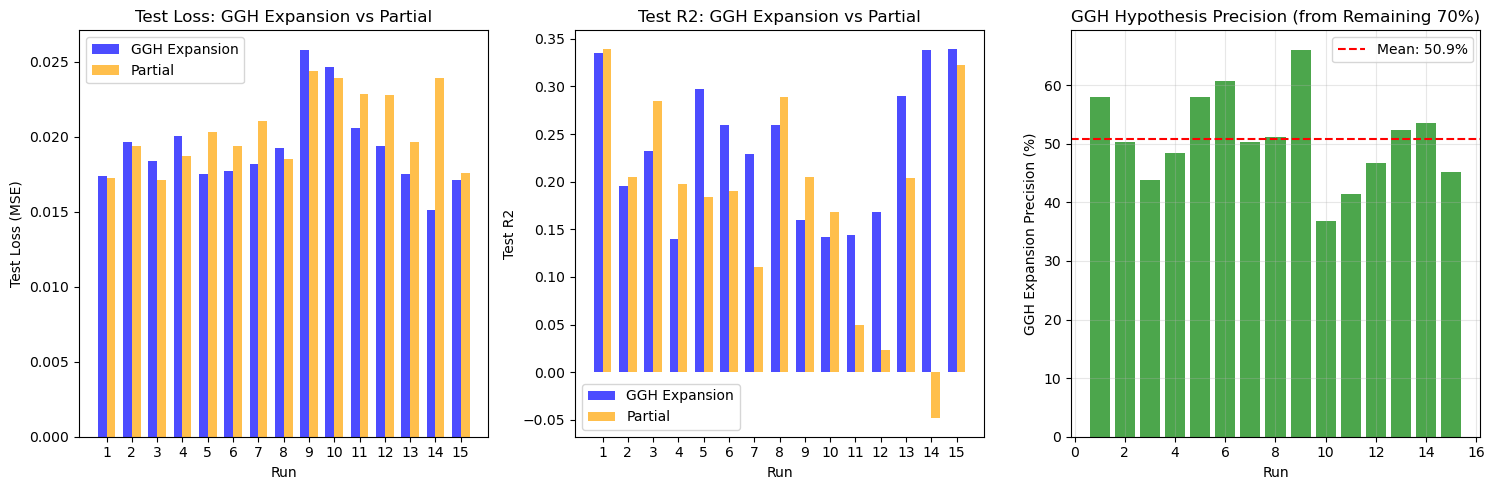


CONCLUSION
No significant difference in Loss (p=0.0985)
No significant difference in R2 (p=0.0922)


In [103]:
# =============================================================================
# BENCHMARK: GGH Expansion Strategy (Like Wine_Hybrid_Iterative) + Enriched Scoring
# =============================================================================
# GGH Method:
#   1. Unbiased training (60 epochs, last 5 tracked) + Enriched selection (top 30%)
#   2. Biased training (30 epochs, lr=0.01) on top 30% + partial
#   3. EXPANSION: Score REMAINING 70% with Enriched+Loss, select top from remaining
#   4. Final model trained on expansion selection + partial
# Partial: Only partial data (~2.5%)
# Both use same final model architecture, validation-based epoch selection
# =============================================================================
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader

# === CONFIGURATION (Matching Wine_Hybrid_Iterative) ===
BENCHMARK_N_RUNS = 15
BENCHMARK_RAND_STATES = [42 + i * 100 for i in range(15)]
BENCHMARK_FINAL_EPOCHS = 200
BENCHMARK_LR = 0.01
BENCHMARK_PARTIAL_WEIGHT = 2.0  # Final model partial weight

# GGH Parameters (Matching Wine_Hybrid_Iterative)
GGH_ITER1_EPOCHS = 60              # 60 epochs (like Wine_Hybrid_Iterative)
GGH_ITER1_ANALYSIS_EPOCHS = 5      # Last 5 tracked (like Wine_Hybrid_Iterative)
GGH_ITER1_LR = 0.01                # lr=0.01 (like Wine_Hybrid_Iterative)
GGH_TOP_PERCENTILE = 30            # Top 30%
GGH_ITER2_EPOCHS = 30              # 30 epochs biased
GGH_ITER2_LR = 0.01                # lr=0.01 (like Wine_Hybrid_Iterative)
GGH_ITER2_PARTIAL_WEIGHT = 2.0     # partial_weight=2.0
GGH_SCORING_PASSES = 5             # 5 passes (like Wine_Hybrid_Iterative)

# Model architecture
MODEL_SHARED_HIDDEN = 16
MODEL_HYPOTHESIS_HIDDEN = 32
MODEL_FINAL_HIDDEN = 32


def create_dataloader_with_gids(DO, batch_size=32):
    """Create dataloader that includes global_ids."""
    input_cols = DO.inpt_vars + [var + '_hypothesis' for var in DO.miss_vars]
    n_samples = len(DO.df_train_hypothesis)
    global_ids = torch.arange(n_samples)
    
    dataset = TensorDataset(
        torch.tensor(DO.df_train_hypothesis[input_cols].values, dtype=torch.float32),
        torch.tensor(DO.df_train_hypothesis[DO.target_vars].values, dtype=torch.float32),
        global_ids
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def train_with_validation(DO, model, trainer_class, selected_gids, partial_gids, 
                          partial_weight, lr, n_epochs=200, batch_size=32):
    """Train model with validation-based epoch selection."""
    dataloader = create_dataloader_with_gids(DO, batch_size)
    
    trainer = trainer_class(DO, model, selected_gids=selected_gids, 
                           partial_gids=partial_gids, partial_weight=partial_weight, lr=lr)
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    
    for epoch in range(n_epochs):
        trainer.train_epoch(dataloader, epoch, track_data=False)
        
        model.eval()
        with torch.no_grad():
            val_inputs, val_targets = DO.get_validation_tensors(use_info="full info")
            val_preds = model(val_inputs)
            val_loss = torch.nn.functional.mse_loss(val_preds, val_targets).item()
        model.train()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    model.load_state_dict(best_state)
    return model, best_epoch, best_val_loss


def evaluate_on_test(DO, model):
    """Evaluate model on test set. Returns loss, MAE, and R2 score."""
    model.eval()
    with torch.no_grad():
        test_inputs, test_targets = DO.get_test_tensors(use_info="full info")
        test_preds = model(test_inputs)
        test_loss = torch.nn.functional.mse_loss(test_preds, test_targets).item()
        test_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
        
        ss_res = torch.sum((test_targets - test_preds) ** 2).item()
        ss_tot = torch.sum((test_targets - test_targets.mean()) ** 2).item()
        r2_score = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    return test_loss, test_mae, r2_score


def compute_enriched_score(gradient, features, class_id, anchor_data):
    """Compute enriched score (gradient + normalized features)."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        grad_scale = anchor_data.get('grad_scale', 1.0)
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    enriched = np.concatenate([gradient, features_norm])
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        anchor_c = anchor_data.get('anchor_correct_grad', {}).get(class_id)
        anchor_i = anchor_data.get('anchor_incorrect_grad', {}).get(class_id)
        enriched = gradient
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data):
    """
    Compute enriched score with loss included (gradient + features + loss).
    For expansion scoring on remaining samples.
    """
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    loss_params = anchor_data.get('loss_norm_params', {}).get(class_id)
    grad_scale = anchor_data.get('grad_scale', 1.0)
    
    # Normalize features
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    # Normalize loss (negated: lower loss = higher value)
    if loss_params:
        loss_norm = -((loss - loss_params['mean']) / loss_params['std']) * loss_params['scale']
    else:
        loss_norm = -loss * grad_scale
    
    # Enriched = gradient + features + loss
    enriched = np.concatenate([gradient, features_norm, [loss_norm]])
    
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def run_ggh_expansion(DO, rand_state):
    """
    Run GGH method with EXPANSION strategy (like Wine_Hybrid_Iterative) but with Enriched scoring.
    
    1. Unbiased training (60 epochs, track last 5) + Enriched selection -> top 30%
    2. Biased training on top 30% + partial (30 epochs)
    3. EXPANSION: Score REMAINING 70% with Enriched+Loss, select best from remaining
    
    Returns selected_gids, precision, partial_correct_gids
    """
    set_to_deterministic(rand_state)
    
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    dataloader = create_dataloader_with_gids(DO, batch_size=32)
    
    # === ITERATION 1: Unbiased training (60 epochs, track last 5) + Enriched selection ===
    model_unbiased = HypothesisAmplifyingModel(n_shared, n_hyp, 
                                               MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN, 
                                               MODEL_FINAL_HIDDEN, out_size)
    trainer_unbiased = UnbiasedTrainer(DO, model_unbiased, lr=GGH_ITER1_LR)
    
    # Train without tracking for first (60-5)=55 epochs
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    
    # Track last 5 epochs
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS, GGH_ITER1_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=True)
    
    # Compute anchors for ENRICHED selection
    anchor_data = compute_anchor_data(trainer_unbiased, DO)
    analysis = trainer_unbiased.get_hypothesis_analysis()
    input_cols = anchor_data['input_cols']
    
    # Select using ENRICHED method (gradient + features)
    all_selections = []
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score, best_is_correct, best_gid, best_class = -np.inf, False, None, None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids or gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            # ENRICHED scoring (gradient + features)
            score = compute_enriched_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                best_gid = gid
                best_class = class_id
        
        if best_score > -np.inf:
            all_selections.append((best_score, best_is_correct, sample_idx, best_gid, best_class))
    
    # Sort and get top 30%
    all_selections.sort(key=lambda x: x[0], reverse=True)
    n_top = int(len(all_selections) * GGH_TOP_PERCENTILE / 100)
    top_selections = all_selections[:n_top]
    top_sample_indices = set(s[2] for s in top_selections)
    sample_to_gid = {s[2]: s[3] for s in all_selections}
    
    # Iter1 precision
    iter1_correct = sum(1 for s in top_selections if s[1])
    iter1_precision = iter1_correct / len(top_selections) * 100 if top_selections else 0
    
    # === ITERATION 2: Biased training on top 30% + partial ===
    set_to_deterministic(rand_state + 100)
    model_biased = HypothesisAmplifyingModel(n_shared, n_hyp,
                                             MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN,
                                             MODEL_FINAL_HIDDEN, out_size)
    
    top_gids_set = set(sample_to_gid[idx] for idx in top_sample_indices if idx in sample_to_gid)
    trainer_biased = BiasedTrainer(DO, model_biased, selected_gids=top_gids_set,
                                   partial_gids=partial_correct_gids, 
                                   partial_weight=GGH_ITER2_PARTIAL_WEIGHT, lr=GGH_ITER2_LR)
    
    for epoch in range(GGH_ITER2_EPOCHS):
        trainer_biased.train_epoch(dataloader, epoch, track_data=False)
    
    # === ITERATION 3: EXPANSION - Score REMAINING 70% with Enriched+Loss ===
    all_sample_indices = set(range(n_samples))
    remaining_sample_indices = all_sample_indices - top_sample_indices - partial_sample_indices
    
    # First, score partial data to build anchors with loss
    partial_scorer = RemainingDataScorer(DO, model_biased, partial_sample_indices)
    partial_scorer.compute_scores(dataloader, n_passes=GGH_SCORING_PASSES)
    partial_analysis = partial_scorer.get_analysis()
    
    # Build anchors with loss from partial data
    anchor_data_biased = {
        'anchor_correct_grad': {},
        'anchor_incorrect_grad': {},
        'anchor_correct_enriched': {},  # Will include loss
        'anchor_incorrect_enriched': {},
        'feature_norm_params': {},
        'loss_norm_params': {},
    }
    
    # Compute normalization parameters
    all_grads = [partial_analysis[gid]['avg_gradient'] for gid in partial_correct_gids | blacklisted_gids
                 if gid in partial_analysis and partial_analysis[gid]['avg_gradient'] is not None]
    grad_scale = np.mean([np.linalg.norm(g) for g in all_grads]) if all_grads else 1.0
    anchor_data_biased['grad_scale'] = grad_scale
    
    inpt_vars_list = DO.inpt_vars
    
    for class_id in range(hyp_per_sample):
        correct_grads, incorrect_grads = [], []
        correct_features, incorrect_features = [], []
        correct_losses, incorrect_losses = [], []
        
        for gid in partial_correct_gids:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    correct_grads.append(partial_analysis[gid]['avg_gradient'])
                    correct_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    correct_losses.append(partial_analysis[gid]['avg_loss'])
        
        for gid in blacklisted_gids:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    incorrect_grads.append(partial_analysis[gid]['avg_gradient'])
                    incorrect_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    incorrect_losses.append(partial_analysis[gid]['avg_loss'])
        
        if correct_grads and incorrect_grads:
            # Gradient anchors
            anchor_data_biased['anchor_correct_grad'][class_id] = np.mean(correct_grads, axis=0)
            anchor_data_biased['anchor_incorrect_grad'][class_id] = np.mean(incorrect_grads, axis=0)
            
            # Feature normalization
            all_features = correct_features + incorrect_features
            feat_mean = np.mean(all_features, axis=0)
            feat_std = np.std(all_features, axis=0) + 1e-8
            anchor_data_biased['feature_norm_params'][class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
            
            correct_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in correct_features]
            incorrect_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in incorrect_features]
            
            # Loss normalization
            all_losses = correct_losses + incorrect_losses
            loss_mean = np.mean(all_losses)
            loss_std = np.std(all_losses) + 1e-8
            anchor_data_biased['loss_norm_params'][class_id] = {'mean': loss_mean, 'std': loss_std, 'scale': grad_scale}
            
            correct_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in correct_losses]
            incorrect_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in incorrect_losses]
            
            # Enriched anchors = gradient + features + loss
            correct_enriched = [np.concatenate([g, f, [l]]) 
                               for g, f, l in zip(correct_grads, correct_features_norm, correct_losses_norm)]
            incorrect_enriched = [np.concatenate([g, f, [l]]) 
                                 for g, f, l in zip(incorrect_grads, incorrect_features_norm, incorrect_losses_norm)]
            
            anchor_data_biased['anchor_correct_enriched'][class_id] = np.mean(correct_enriched, axis=0)
            anchor_data_biased['anchor_incorrect_enriched'][class_id] = np.mean(incorrect_enriched, axis=0)
    
    # Score REMAINING 70%
    scorer = RemainingDataScorer(DO, model_biased, remaining_sample_indices)
    scorer.compute_scores(dataloader, n_passes=GGH_SCORING_PASSES)
    remaining_analysis = scorer.get_analysis()
    
    # Score each hypothesis in remaining samples using Enriched+Loss
    remaining_scored = []
    for sample_idx in remaining_sample_indices:
        start_gid = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_gid = None
        best_is_correct = False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start_gid + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in remaining_analysis or remaining_analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = remaining_analysis[gid]['avg_gradient']
            loss = remaining_analysis[gid]['avg_loss']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64)
            
            # ENRICHED + LOSS scoring
            score = compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data_biased)
            
            if score > best_score:
                best_score = score
                best_gid = gid
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if best_gid is not None:
            remaining_scored.append({
                'sample_idx': sample_idx,
                'gid': best_gid,
                'score': best_score,
                'is_correct': best_is_correct
            })
    
    # Sort remaining by score and take top selections (same count as iter1 top)
    remaining_scored.sort(key=lambda x: x['score'], reverse=True)
    n_take_from_remaining = min(len(remaining_scored), n_top)
    top_remaining = remaining_scored[:n_take_from_remaining]
    
    # Calculate precision on top of remaining (EXPANSION result)
    iter3_correct = sum(1 for s in top_remaining if s['is_correct'])
    iter3_precision = iter3_correct / len(top_remaining) * 100 if top_remaining else 0
    
    # Final selection: use iter3 selections (from remaining 70%)
    selected_gids = set(s['gid'] for s in top_remaining)
    
    print(f"  Iter1 top {GGH_TOP_PERCENTILE}% precision: {iter1_precision:.1f}%")
    print(f"  Iter3 (expansion) remaining scored: {len(remaining_scored)}, top {n_take_from_remaining} precision: {iter3_precision:.1f}%")
    
    return selected_gids, iter3_precision, partial_correct_gids


# =============================================================================
# MAIN COMPARISON LOOP
# =============================================================================
print("=" * 80)
print("BENCHMARK: GGH Expansion (Enriched) vs Partial-Only")
print("=" * 80)
print("GGH Method (Expansion Strategy):")
print(f"  Iter1: {GGH_ITER1_EPOCHS} epochs unbiased (lr={GGH_ITER1_LR}), last {GGH_ITER1_ANALYSIS_EPOCHS} tracked")
print(f"  Iter1: Enriched selection (gradient + features) -> top {GGH_TOP_PERCENTILE}%")
print(f"  Iter2: {GGH_ITER2_EPOCHS} epochs biased (lr={GGH_ITER2_LR}, pw={GGH_ITER2_PARTIAL_WEIGHT}) on top 30% + partial")
print(f"  Iter3: EXPANSION - Score REMAINING 70% with Enriched+Loss, select best")
print(f"  Final: Train on expansion selection + partial (pw={BENCHMARK_PARTIAL_WEIGHT})")
print(f"Partial: Train only on partial data (~2.5%)")
print(f"Both: {BENCHMARK_FINAL_EPOCHS} epochs, validation-based epoch selection, same architecture")
print("=" * 80)

results = []

for run_idx, run_rand_state in enumerate(BENCHMARK_RAND_STATES):
    print(f"\n{'='*60}")
    print(f"RUN {run_idx + 1}/{BENCHMARK_N_RUNS} (rand_state={run_rand_state})")
    print(f"{'='*60}")
    
    # Setup DataOperator
    set_to_deterministic(run_rand_state)
    DO_run = DataOperator(
        data_path, inpt_vars, target_vars, miss_vars, hypothesis,
        partial_perc, run_rand_state, device='cpu',
        data_split={"train": 0.72, "val": 0.88}
    )
    DO_run.problem_type = 'regression'
    
    # Get partial data
    partial_gids = set(DO_run.df_train_hypothesis[
        (DO_run.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO_run.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    n_shared = len(DO_run.inpt_vars)
    n_hyp = len(DO_run.miss_vars)
    out_size = len(DO_run.target_vars)
    
    # === Run GGH Expansion selection ===
    print("Running GGH Expansion selection...")
    ggh_selected_gids, ggh_precision, _ = run_ggh_expansion(DO_run, run_rand_state)
    print(f"  Final GGH precision: {ggh_precision:.1f}% ({len(ggh_selected_gids)} samples)")
    
    # === Train GGH final model ===
    print(f"Training GGH model ({BENCHMARK_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(run_rand_state + 200)
    model_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN, 
                                          MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_ggh, ggh_best_epoch, ggh_best_val_loss = train_with_validation(
        DO_run, model_ggh, BiasedTrainer, 
        selected_gids=ggh_selected_gids, partial_gids=partial_gids,
        partial_weight=BENCHMARK_PARTIAL_WEIGHT, lr=BENCHMARK_LR, n_epochs=BENCHMARK_FINAL_EPOCHS
    )
    ggh_test_loss, ggh_test_mae, ggh_test_r2 = evaluate_on_test(DO_run, model_ggh)
    print(f"GGH: best_epoch={ggh_best_epoch}, val_loss={ggh_best_val_loss:.4f}, "
          f"test_loss={ggh_test_loss:.4f}, test_mae={ggh_test_mae:.4f}, R2={ggh_test_r2:.4f}")
    
    # === Train Partial-only model ===
    print(f"Training Partial model ({BENCHMARK_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(run_rand_state + 300)
    model_partial = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN,
                                              MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size)
    model_partial, partial_best_epoch, partial_best_val_loss = train_with_validation(
        DO_run, model_partial, BiasedTrainer,
        selected_gids=set(), partial_gids=partial_gids,
        partial_weight=1.0, lr=BENCHMARK_LR, n_epochs=BENCHMARK_FINAL_EPOCHS
    )
    partial_test_loss, partial_test_mae, partial_test_r2 = evaluate_on_test(DO_run, model_partial)
    print(f"Partial: best_epoch={partial_best_epoch}, val_loss={partial_best_val_loss:.4f}, "
          f"test_loss={partial_test_loss:.4f}, test_mae={partial_test_mae:.4f}, R2={partial_test_r2:.4f}")
    
    # Store results
    results.append({
        'rand_state': run_rand_state,
        'ggh_precision': ggh_precision,
        'ggh_test_loss': ggh_test_loss,
        'ggh_test_mae': ggh_test_mae,
        'ggh_test_r2': ggh_test_r2,
        'ggh_best_epoch': ggh_best_epoch,
        'partial_test_loss': partial_test_loss,
        'partial_test_mae': partial_test_mae,
        'partial_test_r2': partial_test_r2,
        'partial_best_epoch': partial_best_epoch,
        'improvement_loss': partial_test_loss - ggh_test_loss,  # Positive = GGH better
        'improvement_mae': partial_test_mae - ggh_test_mae,
        'improvement_r2': ggh_test_r2 - partial_test_r2,
    })
    
    print(f"\n>>> Improvement: Loss={results[-1]['improvement_loss']:+.4f}, "
          f"MAE={results[-1]['improvement_mae']:+.4f}, R2={results[-1]['improvement_r2']:+.4f}")


# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n{'='*80}")
print("BENCHMARK RESULTS: GGH Expansion (Enriched) vs Partial-Only")
print(f"{'='*80}")

# Print detailed table
print("\nDetailed Results:")
print(f"{'Run':<5} {'GGH Prec':<10} {'GGH Loss':<12} {'Part Loss':<12} {'Δ Loss':<10} {'GGH R2':<10} {'Part R2':<10} {'Δ R2':<10}")
print("-" * 100)
for i, r in enumerate(results):
    print(f"{i+1:<5} {r['ggh_precision']:<10.1f}% {r['ggh_test_loss']:<12.4f} {r['partial_test_loss']:<12.4f} "
          f"{r['improvement_loss']:+10.4f} {r['ggh_test_r2']:<10.4f} {r['partial_test_r2']:<10.4f} {r['improvement_r2']:+10.4f}")

# Summary statistics
ggh_losses = [r['ggh_test_loss'] for r in results]
partial_losses = [r['partial_test_loss'] for r in results]
ggh_r2s = [r['ggh_test_r2'] for r in results]
partial_r2s = [r['partial_test_r2'] for r in results]
ggh_precisions = [r['ggh_precision'] for r in results]

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"\nGGH Expansion Precision: {np.mean(ggh_precisions):.1f}% ± {np.std(ggh_precisions):.1f}%")
print(f"\nTest Loss (MSE):")
print(f"  GGH:     {np.mean(ggh_losses):.4f} ± {np.std(ggh_losses):.4f}")
print(f"  Partial: {np.mean(partial_losses):.4f} ± {np.std(partial_losses):.4f}")
print(f"\nTest R2 Score:")
print(f"  GGH:     {np.mean(ggh_r2s):.4f} ± {np.std(ggh_r2s):.4f}")
print(f"  Partial: {np.mean(partial_r2s):.4f} ± {np.std(partial_r2s):.4f}")

# Statistical tests
t_stat_loss, p_value_loss = stats.ttest_rel(ggh_losses, partial_losses)
t_stat_r2, p_value_r2 = stats.ttest_rel(ggh_r2s, partial_r2s)

print(f"\nStatistical Tests (paired t-test):")
print(f"  Loss: t={t_stat_loss:.3f}, p={p_value_loss:.4f} {'*' if p_value_loss < 0.05 else ''}")
print(f"  R2:   t={t_stat_r2:.3f}, p={p_value_r2:.4f} {'*' if p_value_r2 < 0.05 else ''}")

# Win/Loss count
n_ggh_wins_loss = sum(1 for r in results if r['ggh_test_loss'] < r['partial_test_loss'])
n_ggh_wins_r2 = sum(1 for r in results if r['ggh_test_r2'] > r['partial_test_r2'])
print(f"\nWin Rate:")
print(f"  GGH wins (Loss): {n_ggh_wins_loss}/{BENCHMARK_N_RUNS} ({n_ggh_wins_loss/BENCHMARK_N_RUNS*100:.1f}%)")
print(f"  GGH wins (R2):   {n_ggh_wins_r2}/{BENCHMARK_N_RUNS} ({n_ggh_wins_r2/BENCHMARK_N_RUNS*100:.1f}%)")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(BENCHMARK_N_RUNS)
width = 0.35

# Plot 1: Test Loss comparison
ax1 = axes[0]
ax1.bar(x - width/2, ggh_losses, width, label='GGH Expansion', color='blue', alpha=0.7)
ax1.bar(x + width/2, partial_losses, width, label='Partial', color='orange', alpha=0.7)
ax1.set_xlabel('Run')
ax1.set_ylabel('Test Loss (MSE)')
ax1.set_title('Test Loss: GGH Expansion vs Partial')
ax1.legend()
ax1.set_xticks(x)
ax1.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])

# Plot 2: R2 comparison
ax2 = axes[1]
ax2.bar(x - width/2, ggh_r2s, width, label='GGH Expansion', color='blue', alpha=0.7)
ax2.bar(x + width/2, partial_r2s, width, label='Partial', color='orange', alpha=0.7)
ax2.set_xlabel('Run')
ax2.set_ylabel('Test R2')
ax2.set_title('Test R2: GGH Expansion vs Partial')
ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])

# Plot 3: GGH Precision across runs
ax3 = axes[2]
ax3.bar(range(1, BENCHMARK_N_RUNS+1), ggh_precisions, color='green', alpha=0.7)
ax3.axhline(y=np.mean(ggh_precisions), color='red', linestyle='--', label=f'Mean: {np.mean(ggh_precisions):.1f}%')
ax3.set_xlabel('Run')
ax3.set_ylabel('GGH Expansion Precision (%)')
ax3.set_title('GGH Hypothesis Precision (from Remaining 70%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{results_path}/ggh_expansion_enriched_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
avg_improvement_loss = np.mean([r['improvement_loss'] for r in results])
avg_improvement_r2 = np.mean([r['improvement_r2'] for r in results])
if avg_improvement_loss > 0 and p_value_loss < 0.05:
    print(f"GGH Expansion significantly OUTPERFORMS Partial-only on Loss (p={p_value_loss:.4f})")
    print(f"Average loss improvement: {avg_improvement_loss:.4f} MSE")
elif avg_improvement_loss < 0 and p_value_loss < 0.05:
    print(f"Partial-only significantly OUTPERFORMS GGH Expansion on Loss (p={p_value_loss:.4f})")
else:
    print(f"No significant difference in Loss (p={p_value_loss:.4f})")

if avg_improvement_r2 > 0 and p_value_r2 < 0.05:
    print(f"GGH Expansion significantly OUTPERFORMS Partial-only on R2 (p={p_value_r2:.4f})")
    print(f"Average R2 improvement: {avg_improvement_r2:.4f}")
elif avg_improvement_r2 < 0 and p_value_r2 < 0.05:
    print(f"Partial-only significantly OUTPERFORMS GGH Expansion on R2 (p={p_value_r2:.4f})")
else:
    print(f"No significant difference in R2 (p={p_value_r2:.4f})")
